In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats

In [2]:
import Loader
ldr = Loader.Loader()
conn = pymysql.connect(host='localhost',user='root',
                                   password='tlqkfdk2',db='INVESTAR',charset='utf8')

In [3]:
def GetExpectedReturn_v2(df, initial=True):
    if initial:
        start_date = df.index[0]
        with open("./TradingDates.pickle","rb") as fr :
            td_days = pickle.load(fr)
        idx = td_days.index(df.index[0])
        dates = td_days[idx-19:idx+1]
        sub_df = ldr.GetPrice(dates[0],dates[-1],list(df.columns),item='adjprice',colname='code')
        tdf = df.copy()
        tdf.iloc[0,:] = sub_df.mean().values
        return (tdf - tdf.iloc[0,:]) / tdf.iloc[0,:]
    else :
        return ((df - df.shift(1)) / df.shift(1)).fillna(0)

In [14]:
def SectorAnalysis_v3(dt, rt_code=True):
    conn = pymysql.connect(host='localhost',user='root',password='tlqkfdk2',db='INVESTAR',charset='utf8')
    comp_info = pd.read_sql("select code, sector from company_info",conn)
    code_ls = list(comp_info.code.values)
    sector_dict = {}
    for i in range(len(comp_info)):
        sector_dict[comp_info.loc[i,'code']] = comp_info.loc[i,'sector']
    cn = conn.cursor()
    cn.execute("select max(date) from daily_price where code='005930'")
    last_update = cn.fetchone()[0].strftime("%Y-%m-%d")
    
    if dt[5:7] == '09':
        start = dt[:4]+'-11-20'
        end = str(int(dt[:4])+1)+'-03-10'
    elif dt[5:7] == '03':
        start = dt[:4]+'-05-20'
        end = dt[:4]+'-08-10'
    elif dt[5:7] == '06':
        start = dt[:4]+'-08-20'
        end = dt[:4]+'-11-10'
    elif dt[5:7] == '12':
        end = str(int(dt[:4])+2)+'-02-28'
        start = str(int(dt[:4])+1)+'-03-31'
    else :
        raise ValueError("Date is not correct.")
    
    if end > last_update :
        end = last_update
    funda = SummaryFunda_v2(dt)
    funda['sector'] = funda.index.map(sector_dict)
    exist_ls = list(funda.index)
    df = ldr.GetPrice(start, end, exist_ls, item='adjprice', colname='code')
    df = df.dropna(axis=1,how='any')
    df = GetExpectedReturn_v2(df,True)
    tmp = pd.DataFrame(index = list(df.columns), columns=['sector'])
    tmp['sector'] = tmp.index.map(sector_dict)
    sctr_ls = list(tmp['sector'].value_counts()[lambda x : x>=20].index)
    rst = pd.DataFrame(columns=['FD-Q','C1','C1(%)','C1(T)','C2-GMean','C2-Mean''Codes'])
    
    for sc in sctr_ls :
        sc_idx = list(tmp[lambda x : x['sector']==sc].index)
        sub_funda = Labeling(funda[funda.index.isin(sc_idx)].drop(['sector'],axis=1), qtl=3)
        #total_top = pd.DataFrame(index = [sc], columns=['FD-Q','C1','C1(%)','C1(T)','C21-GMean','C21-Mean','C22-GMean','C22-Mean'])
        for fd in funda.columns[:-1]:
            #total_mid = pd.DataFrame(index = [sc], columns=['FD-Q','C1','C1(%)','C1(T)','C21-GMean','C21-Mean','C22-GMean','C22-Mean'])
            for ith in [1,2,3]:
                total = pd.DataFrame(index = [sc], columns=['FD-Q','C1','C1(%)','C1(T)','C2-GMean','C2-Mean','Codes'])
                total.loc[sc,'FD-Q'] = fd+'-'+str(ith)
                sc_idx_ith = list(sub_funda[lambda x : x[fd]==ith].index)
                sub_df = df[sc_idx_ith]
                total.loc[sc,'Codes'] = sc_idx_ith
                cnt = 0
                c1_ls = []
                gmeans = []
                gmeans_m = []
                means = []
                means_m = []
                for cl in sub_df.columns :
                    if len(sub_df[lambda x : x[cl]>=0.3])>0 or (sub_df[cl].values[-1]>=0.2) :
                        if len(sub_df[lambda x : x[cl]<=-0.23])==0 :
                            cnt += 1
                            c1_ls.append(cl)
                    tmp_df = sub_df+1
                    gmeans.append(np.exp(np.log(tmp_df.T.prod(axis=1))/tmp_df.T.notna().sum(1)).values[0])
                    means.append(tmp_df[cl].mean())
                    if tmp_df[cl].mean == np.nan:
                        print(cl)

                    
                
                total.loc[sc,'C1'] = cnt
                total.loc[sc,'C1(%)'] = cnt / len(sc_idx_ith)
                total.loc[sc,'C1(T)'] = len(sc_idx_ith)

                gmean_df = pd.DataFrame(gmeans).T
                total.loc[sc,'C2-GMean'] = np.exp(np.log(gmean_df.prod(axis=1))/gmean_df.notna().sum(1)).values[0]
                total.loc[sc,'C2-Mean'] = pd.Series(means).mean()

                
                rst = pd.concat([rst, total])
        
        
    rst.sort_values(by=['C1(%)','C2-GMean'],ascending=False,inplace=True)
    return rst

In [15]:
def SummaryFunda_v2(dt, funda_ls=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']):
    """Paradox of Simpson"""
    #rst1 = SummaryDataFrame('2016-12','2018-02-15',term=10,funda_ls=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
    with open("./TradingDates.pickle","rb") as fr :
        td_days = pickle.load(fr)
    conn = pymysql.connect(host='localhost',user='root', password='tlqkfdk2',db='INVESTAR',charset='utf8')
    comp_info = pd.read_sql("select code, sector from company_info",conn)
    code_ls = list(comp_info.code.values)
    #filtered_ls = Filtering(dt, conn, by=['PBR','PCR','POR'])
    print("Initial Filtered Univ : {}".format(len(code_ls)))
    print("EX : {}".format(code_ls[:5]))
    total = pd.DataFrame(index = code_ls, columns = funda_ls)
    fn_df = pd.read_sql(f"select code, itm, value from finance_info_copy where code in {tuple(code_ls)} and date='{dt}' and itm in {tuple(funda_ls)}",conn)
    fn_df = fn_df[lambda x : x['value']!=-999.9]
    for idx, row in fn_df.iterrows():
        if row.itm in ['PBR','PER','PCR','POR','PSR']:
            total.loc[row.code, row.itm] = float(row.value) / 100000000
        elif row.itm in ['EPS','BPS']:
            total.loc[row.code, row.itm] = float(row.value) * 100000000
        else :
            total.loc[row.code, row.itm] = float(row.value)
    
    total = total.dropna(axis=0,how='any').dropna(axis=1,how='any')
    return total.astype(float)

In [16]:
def Labeling(df, qtl=5):
    """Summary df should be inserted"""
    rst = df.copy()
    for c in df.columns :
        tmp_dict = {}
        for i, e in enumerate(list(df.groupby(pd.qcut(df[c],qtl)).agg(['mean']).index)):
            tmp_dict[e] = i+1
        rst[c] = pd.qcut(df[c],qtl).map(tmp_dict)
    return rst

In [108]:
%%time
dt = '2019-12'
sc2019 = SectorAnalysis_v3(dt,True)

Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Wall time: 1min 53s


In [124]:
%%time
dt = '2018-12'
sc2018 = SectorAnalysis_v3(dt,True)

Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Wall time: 1min 36s


In [125]:
%%time
dt = '2017-12'
sc2017 = SectorAnalysis_v3(dt,True)

Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Wall time: 1min 22s


In [126]:
%%time
dt = '2016-12'
sc2016 = SectorAnalysis_v3(dt,True)

Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Wall time: 1min 19s


In [13]:
def AnnualSectorDist_v4(sc_df_ls, initial=True):
    """sc_df_ls = [sc2016,sc2017,sc2018,sc2019]"""
    rst = pd.DataFrame(columns=['Date','Funda','Pattern','C31-Best','C31-Count','C32-Best','C32-Count','C33-Best','C33-Count'])
    year = 2016
    for df in sc_df_ls:
        if year == 2019 :
            start = str(year+1)+'-03-31'
            end = str(year+1)+'-12-31'
        else :
            start = str(year+1)+'-03-31'
            end = str(year+2)+'-02-28'
        for sc in list(set(df.index)):
            for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
                tmp = pd.DataFrame(index=[sc],columns=['Date','Funda','Pattern','C31-Best','C31-Count','C32-Best','C32-Count','C33-Best','C33-Count'])
                ger_total = pd.DataFrame()
                mer_total = pd.DataFrame()
                positives = []
                for ith in ['1','2','3']:
                    sc_idx = df[df['FD-Q'].isin([fd+'-'+ith])]['Codes'].values[0]
                    pr = ldr.GetPrice(start, end, sc_idx, item='adjprice',colname='code')
                    pr = pr.dropna(axis=1,how='any')
                    er = GetExpectedReturn_v2(pr,initial) +1
                    gm_pr = pd.DataFrame(np.exp(np.log(er.prod(axis=1))/er.notna().sum(1)),columns=[fd+'-'+ith])
                    am_pr = pd.DataFrame(er.T.mean(), columns=[fd+'-'+ith])
                    ger_total = pd.concat([ger_total, gm_pr],axis=1).dropna(axis=0,how='any')
                    mer_total = pd.concat([mer_total, am_pr],axis=1).dropna(axis=0,how='any')
                    positives.append(len(gm_pr[lambda x : x[fd+'-'+ith]>=1]))
                a = b = c = 0
                for d in list(ger_total.index):
                    idx = ger_total.loc[d].idxmax()
                    if idx == fd+'-1': a+=1
                    elif idx == fd+'-2' : b+=1
                    elif idx == fd+'-3' : c+=1
                    else : raise ValueError("Can't be !!!")
                var = {a:'1', b:'2', c:'3'}
                tmp.loc[sc,'C31-Best'] = var.get(max(var))
                tmp.loc[sc,'C31-Count'] = [a,b,c]
                x = y = z = 0
                for d in list(mer_total.index):
                    idx = mer_total.loc[d].idxmax()
                    if idx == fd+'-1': x+=1
                    elif idx == fd+'-2' : y+=1
                    elif idx == fd+'-3' : z+=1
                    else : raise ValueError("Can't be !!!")
                var2 = {x:'1', y:'2', z:'3'}
                tmp.loc[sc,'C32-Best'] = var2.get(max(var2))
                var3 = {positives[0]:'1', positives[1]:'2', positives[2]:'3'}
                tmp.loc[sc,'C33-Best'] = var3.get(max(var3))
                tmp.loc[sc,'C33-Count'] = positives
                tmp.loc[sc,'C32-Count'] = [x,y,z]
                tmp.loc[sc,'Date'] = str(year)+'-12'
                tmp.loc[sc,'Funda'] = fd
                if tmp.loc[sc,'C31-Best'] == tmp.loc[sc,'C32-Best']:
                    tmp.loc[sc,'Pattern'] = 'Y'
                else :
                    tmp.loc[sc,'Pattern'] = 'N'
                rst = pd.concat([rst,tmp])
        year += 1
    return rst

In [264]:
%%time
resec = AnnualSectorDist_v4(sec_year,True)

Wall time: 9min 18s


In [265]:
resec

Date Funda Pattern C31-Best      C31-Count C32-Best  \
기초 화학물질 제조업     2016-12   PBR       N        2  [1, 121, 100]        3   
기초 화학물질 제조업     2016-12   PCR       Y        1  [176, 18, 28]        1   
기초 화학물질 제조업     2016-12   POR       Y        1  [102, 63, 57]        1   
기초 화학물질 제조업     2016-12   PSR       Y        2  [21, 119, 82]        2   
기초 화학물질 제조업     2016-12   PER       Y        1  [171, 35, 16]        1   
...                 ...   ...     ...      ...            ...      ...   
기타 금속 가공제품 제조업  2019-12   EPS       Y        3   [5, 11, 171]        3   
기타 금속 가공제품 제조업  2019-12   BPS       Y        1   [152, 27, 8]        1   
기타 금속 가공제품 제조업  2019-12   ROE       Y        3    [1, 0, 186]        3   
기타 금속 가공제품 제조업  2019-12   ROA       Y        3    [1, 0, 186]        3   
기타 금속 가공제품 제조업  2019-12  시가총액       Y        1   [170, 4, 13]        1   

                    C32-Count C33-Best        C33-Count  
기초 화학물질 제조업     [1, 109, 112]        3  [167, 222, 222]  
기초 화학물질 제조업     [172, 20, 30]        3  [222, 215, 222]  
기초 화학물질 제조업     [111, 54, 57]        3  [220, 222, 222]  
기초 화학물질 제조업     [19, 120, 83]        3  [220, 222, 222]  
기초 화학물질 제조업     [170, 30, 22]        3  [222, 222, 222]  
...                       ...      ...              ...  
기타 금속 가공제품 제조업    [9, 9, 169]        3  [187, 187, 187]  
기타 금속 가공제품 제조업   [166, 14, 7]        3  [187, 187, 187]  
기타 금속 가공제품 제조업    [1, 2, 184]        3  [184, 187, 187]  
기타 금속 가공제품 제조업    [1, 0, 186]        3  [184, 187, 187]  
기타 금속 가공제품 제조업   [170, 5, 12]        3  [187, 184, 187]  

[1080 rows x 9 columns]

In [268]:
resec[resec.index.isin(['반도체 제조업'])&(resec['Pattern']=='Y')&(resec.Funda.isin(['PCR']))]

Date Funda Pattern C31-Best       C31-Count C32-Best  \
반도체 제조업  2016-12   PCR       Y        1   [176, 18, 28]        1   
반도체 제조업  2017-12   PCR       Y        1    [148, 73, 1]        1   
반도체 제조업  2018-12   PCR       Y        1  [110, 106, 11]        1   
반도체 제조업  2019-12   PCR       Y        3    [14, 0, 173]        3   

             C32-Count C33-Best        C33-Count  
반도체 제조업  [172, 20, 30]        3  [222, 215, 222]  
반도체 제조업   [174, 48, 0]        1   [127, 112, 56]  
반도체 제조업   [163, 61, 3]        2  [216, 223, 216]  
반도체 제조업   [16, 0, 171]        3  [187, 187, 187]

In [12]:
def AnnualSectorDist_v3(sc_df_ls, initial=True):
    """sc_df_ls = [sc2016,sc2017,sc2018,sc2019]"""
    rst = pd.DataFrame(columns=['Date','Funda','Pattern','C31-Best','C32-Best'])
    year = 2016
    for df in sc_df_ls:
        if year == 2019 :
            start = str(year+1)+'-03-31'
            end = str(year+1)+'-12-31'
        else :
            start = str(year+1)+'-03-31'
            end = str(year+2)+'-02-28'
        for sc in list(set(df.index)):
            for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
                tmp = pd.DataFrame(index=[sc],columns=['Date','Funda','Pattern','C31-Best','C32-Best'])
                ger_total = pd.DataFrame()
                mer_total = pd.DataFrame()
                for ith in ['1','2','3']:
                    sc_idx = df[df['FD-Q'].isin([fd+'-'+ith])]['Codes'].values[0]
                    pr = ldr.GetPrice(start, end, sc_idx, item='adjprice',colname='code')
                    pr = pr.dropna(axis=1,how='any')
                    er = GetExpectedReturn_v2(pr,initial) +1
                    gm_pr = pd.DataFrame(np.exp(np.log(er.prod(axis=1))/er.notna().sum(1)),columns=[fd+'-'+ith])
                    am_pr = pd.DataFrame(er.T.mean(), columns=[fd+'-'+ith])
                    ger_total = pd.concat([ger_total, gm_pr],axis=1).dropna(axis=0,how='any')
                    mer_total = pd.concat([mer_total, am_pr],axis=1).dropna(axis=0,how='any')
                a = b = c = 0
                for d in list(ger_total.index):
                    idx = ger_total.loc[d].idxmax()
                    if idx == fd+'-1': a+=1
                    elif idx == fd+'-2' : b+=1
                    elif idx == fd+'-3' : c+=1
                    else : raise ValueError("Can't be !!!")
                var = {a:fd+'-1', b:fd+'-2', c:fd+'-3'}
                tmp.loc[sc,'C31-Best'] = var.get(max(var))
                x = y = z = 0
                for d in list(mer_total.index):
                    idx = mer_total.loc[d].idxmax()
                    if idx == fd+'-1': x+=1
                    elif idx == fd+'-2' : y+=1
                    elif idx == fd+'-3' : z+=1
                    else : raise ValueError("Can't be !!!")
                var2 = {x:fd+'-1', y:fd+'-2', z:fd+'-3'}
                tmp.loc[sc,'C32-Best'] = var2.get(max(var2))
                tmp.loc[sc,'Date'] = str(year)+'-12'
                tmp.loc[sc,'Funda'] = fd
                if tmp.loc[sc,'C31-Best'] == tmp.loc[sc,'C32-Best']:
                    tmp.loc[sc,'Pattern'] = 'Y'
                else :
                    tmp.loc[sc,'Pattern'] = 'N'
                rst = pd.concat([rst,tmp])
        year += 1
    return rst

In [196]:
%%time
sec_year = [sc2016,sc2017,sc2018,sc2019]
qrqr = AnnualSectorDist_v3(sec_year)

Wall time: 9min 10s


In [10]:
def AnnualSectorDist_v2(sc_df_ls):
    """sc_df_ls = [sc2016,sc2017,sc2018,sc2019]"""
    rst = pd.DataFrame(columns=['Date','Funda','Pattern','C2-GBest','C2-MBest'])
    year = 2016
    for df in sc_df_ls:
        for sc in list(set(df.index)):
            for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
                tmp = pd.DataFrame(index=[sc],columns=['Date','Funda','Pattern','C2-GBest','C2-MBest'])
                sub_df = df[df['FD-Q'].isin([fd+'-'+str(i) for i in [1,2,3]])].loc[sc]
                tmp.loc[sc,'Date'] = str(year)+'-12'
                tmp.loc[sc,'Funda'] = fd
                tmp.loc[sc,'C2-GBest'] = sub_df.sort_values(by=['C2-GMean'],ascending=False).loc[sc,'FD-Q'][0][-1]
                tmp.loc[sc,'C2-MBest'] = sub_df.sort_values(by=['C2-Mean']).loc[sc,'FD-Q'][0][-1]
                if tmp.loc[sc,'C2-GBest'] == tmp.loc[sc,'C2-MBest']:
                    tmp.loc[sc,'Pattern'] = 'Y'
                else :
                    tmp.loc[sc,'Pattern'] = 'N'
                rst = pd.concat([rst,tmp])
        year += 1
    return rst

In [11]:
def AnnualSectorDist(sc_df_ls):
    """sc_df_ls = [sc2016,sc2017,sc2018,sc2019]"""
    rst = pd.DataFrame(columns=['Date','Funda','Pattern','C21-Best','C22-Best'])
    year = 2016
    for df in sc_df_ls:
        for sc in list(set(df.index)):
            for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
                tmp = pd.DataFrame(index=[sc],columns=['Date','Funda','Pattern','C21-Best','C22-Best'])
                sub_df = df[df['FD-Q'].isin([fd+'-'+str(i) for i in [1,2,3]])].loc[sc]
                tmp.loc[sc,'Date'] = str(year)+'-12'
                tmp.loc[sc,'Funda'] = fd
                tmp.loc[sc,'C21-Best'] = sub_df.sort_values(by=['C21-GMean'],ascending=False).loc[sc,'FD-Q'][0][-1]
                tmp.loc[sc,'C22-Best'] = sub_df.sort_values(by=['C22-GMean']).loc[sc,'FD-Q'][0][-1]
                if tmp.loc[sc,'C21-Best'] == tmp.loc[sc,'C22-Best']:
                    tmp.loc[sc,'Pattern'] = 'Y'
                else :
                    tmp.loc[sc,'Pattern'] = 'N'
                rst = pd.concat([rst,tmp])
        year += 1
    return rst

In [127]:
%%time
sec_year = [sc2016,sc2017,sc2018,sc2019]
rst_Y_v2 = AnnualSectorDist_v2(sec_year)

Wall time: 4.36 s


In [130]:
rst_Y

Date Funda Pattern C21-Best C22-Best
기초 화학물질 제조업     2016-12   PBR       Y        2        2
기초 화학물질 제조업     2016-12   PCR       Y        2        2
기초 화학물질 제조업     2016-12   POR       Y        1        1
기초 화학물질 제조업     2016-12   PSR       Y        1        1
기초 화학물질 제조업     2016-12   PER       Y        1        1
...                 ...   ...     ...      ...      ...
기타 금속 가공제품 제조업  2019-12   EPS       N        2        1
기타 금속 가공제품 제조업  2019-12   BPS       N        2        1
기타 금속 가공제품 제조업  2019-12   ROE       N        2        1
기타 금속 가공제품 제조업  2019-12   ROA       N        2        1
기타 금속 가공제품 제조업  2019-12  시가총액       N        1        3

[1050 rows x 5 columns]

In [9]:
def Patternize_v3(sec_df, fltr=None):
    """3 : 0.5/0.3/0.2 | 4 :"""
    total = pd.DataFrame(columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
    for sc in list(set(sec_df.index)):
        tmp = pd.DataFrame(index=[sc],columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
        for fd in list(set(sec_df.Funda.values)):
            try :
                sub_df = sec_df[(sec_df.Pattern=='Y')&(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                #tmp = pd.DataFrame(index=[sc],columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
                if len(sub_df)==4 :
                    if len(set(sub_df['C32-Best'].values))==1:
                        tmp.loc[sc,fd] = str(sub_df['C32-Best'].values[0]) + '-Type1'
                    elif len(set(sub_df['C32-Best'].values))==2:
                        tmp.loc[sc,fd] = str(sub_df.sort_values(by=['Date'])['C32-Best'].values[-1]) + '-Type2'
                    elif len(set(sub_df['C32-Best'].values))==3:
                        tmp.loc[sc,fd] = str(sub_df['C32-Best'].value_counts().sort_values(ascending=False).index[0]) + '-Type3'
                    else : # 이 경우는 없겠네;; 분할이 1~3 뿐이니까
                        #tmp.loc[sc,fd] = '-1-Type4'
                        pass
                elif len(sub_df)!=0:
                    sub_df = sec_df[(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                    tmp.loc[sc,fd] = str(sub_df['C32-Best'].value_counts().sort_values(ascending=False).index[0]) + '-Type4'
                else :
                    sub_df = sec_df[(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                    tmp.loc[sc,fd] = str(sub_df['C32-Best'].value_counts().sort_values(ascending=False).index[0]) + '-Type5'
            except :
                pass
        total = pd.concat([total,tmp])
        
    if fltr == None :
        return total
    else :
        for sc in list(total.index) :
            for fd in list(total.columns):
                if total.loc[sc,fd].split('-')[-1] in fltr :
                    total.loc[sc,fd] = np.nan
        return total

In [221]:
%%time

go2 = Patternize_v3(qrqr33)

Wall time: 648 ms


In [212]:
%%time

go = Patternize_v3(qrqr33)

Wall time: 642 ms


In [213]:
go

PBR      PCR      POR      PSR  \
기초 화학물질 제조업                            2-Type4  3-Type2  1-Type4  2-Type1   
의료용 기기 제조업                             2-Type4  3-Type2  1-Type4  2-Type1   
통신 및 방송 장비 제조업                         2-Type4  3-Type2  1-Type4  2-Type1   
기타 금융업                                 2-Type4  3-Type2  1-Type4  2-Type1   
의약품 제조업                                2-Type4  3-Type2  1-Type4  2-Type1   
특수 목적용 기계 제조업                          2-Type4  3-Type2  1-Type4  2-Type1   
측정, 시험, 항해, 제어 및 기타 정밀기기 제조업; 광학기기 제외  1-Type4  1-Type4  2-Type4  2-Type4   
기타 식품 제조업                              2-Type4  3-Type2  1-Type4  2-Type1   
소프트웨어 개발 및 공급업                         2-Type4  3-Type2  1-Type4  2-Type1   
구조용 금속제품, 탱크 및 증기발생기 제조업               2-Type4  3-Type4  2-Type4  2-Type4   
자동차 신품 부품 제조업                          2-Type4  3-Type2  1-Type4  2-Type1   
전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업      2-Type4  3-Type2  1-Type4  2-Type1   
금융 지원 서비스업                             2-Type4  3-Type2  1-Type4  2-Type1   
기타 전문 도매업                              2-Type4  3-Type2  1-Type4  2-Type1   
자연과학 및 공학 연구개발업                        2-Type4  3-Type4  2-Type4  2-Type4   
영화, 비디오물, 방송프로그램 제작 및 배급업              2-Type4  3-Type2  1-Type4  2-Type1   
반도체 제조업                                2-Type4  3-Type2  1-Type4  2-Type1   
컴퓨터 프로그래밍, 시스템 통합 및 관리업                2-Type4  3-Type2  1-Type4  2-Type1   
기초 의약물질 및 생물학적 제제 제조업                  2-Type4  3-Type2  1-Type4  2-Type1   
의료용품 및 기타 의약 관련제품 제조업                  2-Type4  3-Type4  2-Type5  2-Type4   
봉제의복 제조업                               2-Type4  3-Type2  1-Type4  2-Type1   
일반 목적용 기계 제조업                          2-Type4  3-Type2  1-Type4  2-Type1   
전자부품 제조업                               2-Type4  3-Type2  1-Type4  2-Type1   
건물 건설업                                 2-Type4  3-Type2  1-Type4  2-Type1   
플라스틱제품 제조업                             2-Type4  3-Type2  1-Type4  2-Type1   
1차 철강 제조업                              2-Type4  3-Type2  1-Type4  2-Type1   
기타 화학제품 제조업                            2-Type4  3-Type2  1-Type4  2-Type1   
기계장비 및 관련 물품 도매업                       2-Type4  3-Type2  1-Type4  2-Type1   
기타 금속 가공제품 제조업                         2-Type4  3-Type2  1-Type4  2-Type1   

                                           PER      EPS      BPS      ROE  \
기초 화학물질 제조업                            3-Type3  2-Type3  1-Type2  1-Type4   
의료용 기기 제조업                             3-Type3  2-Type3  1-Type2  1-Type4   
통신 및 방송 장비 제조업                         3-Type3  2-Type3  1-Type2  1-Type4   
기타 금융업                                 3-Type3  2-Type3  1-Type2  1-Type4   
의약품 제조업                                3-Type3  2-Type3  1-Type2  1-Type4   
특수 목적용 기계 제조업                          3-Type3  2-Type3  1-Type2  1-Type4   
측정, 시험, 항해, 제어 및 기타 정밀기기 제조업; 광학기기 제외  3-Type4  2-Type4  3-Type4  2-Type4   
기타 식품 제조업                              3-Type3  2-Type3  1-Type2  1-Type4   
소프트웨어 개발 및 공급업                         3-Type3  2-Type3  1-Type2  1-Type4   
구조용 금속제품, 탱크 및 증기발생기 제조업               2-Type4  2-Type4  3-Type4  2-Type4   
자동차 신품 부품 제조업                          3-Type3  2-Type3  1-Type2  1-Type4   
전동기, 발전기 및 전기 변환 · 공급 · 제어 장치 제조업      3-Type3  2-Type3  1-Type2  1-Type4   
금융 지원 서비스업                             3-Type3  2-Type3  1-Type2  1-Type4   
기타 전문 도매업                              3-Type3  2-Type3  1-Type2  1-Type4   
자연과학 및 공학 연구개발업                        2-Type4  2-Type4  3-Type4  2-Type4   
영화, 비디오물, 방송프로그램 제작 및 배급업              3-Type3  2-Type3  1-Type2  1-Type4   
반도체 제조업                                3-Type3  2-Type3  1-Type2  1-Type4   
컴퓨터 프로그래밍, 시스템 통합 및 관리업                3-Type3  2-Type3  1-Type2  1-Type4   
기초 의약물질 및 생물학적 제제 제조업                  3-Type3  2-Type3  1-Type2  1-Type4   
의료용품 및 기타 의약 관련제품 제조업                  3-Type4  3-Type4  1-Type4  3-Type4   
봉제의복 제조업                               3-Type3  2-Type3  1-Type2  1-Type4   
일반 목적용 기계 제조업                         

In [134]:
def Patternize_v2(sec_df, fltr=None):
    """3 : 0.5/0.3/0.2 | 4 :"""
    total = pd.DataFrame(columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
    for sc in list(set(sec_df.index)):
        tmp = pd.DataFrame(index=[sc],columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
        for fd in list(set(sec_df.Funda.values)):
            try :
                sub_df = sec_df[(sec_df.Pattern=='Y')&(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                #tmp = pd.DataFrame(index=[sc],columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
                if len(sub_df)==4 :
                    if len(set(sub_df['C2-GBest'].values))==1:
                        tmp.loc[sc,fd] = str(sub_df['C2-GBest'].values[0]) + '-Type1'
                    elif len(set(sub_df['C2-GBest'].values))==2:
                        tmp.loc[sc,fd] = str(sub_df.sort_values(by=['Date'])['C2-GBest'].values[-1]) + '-Type2'
                    elif len(set(sub_df['C2-GBest'].values))==3:
                        tmp.loc[sc,fd] = str(sub_df['C2-GBest'].value_counts().sort_values(ascending=False).index[0]) + '-Type3'
                    else : # 이 경우는 없겠네;; 분할이 1~3 뿐이니까
                        #tmp.loc[sc,fd] = '-1-Type4'
                        pass
                elif len(sub_df)!=0:
                    sub_df = sec_df[(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                    tmp.loc[sc,fd] = str(sub_df['C2-GBest'].value_counts().sort_values(ascending=False).index[0]) + '-Type4'
                else :
                    sub_df = sec_df[(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                    tmp.loc[sc,fd] = str(sub_df['C2-GBest'].value_counts().sort_values(ascending=False).index[0]) + '-Type5'
            except :
                pass
        total = pd.concat([total,tmp])
        
    if fltr == None :
        return total
    else :
        for sc in list(total.index) :
            for fd in list(total.columns):
                if total.loc[sc,fd].split('-')[-1] in fltr :
                    total.loc[sc,fd] = np.nan
        return total

In [93]:
def Patternize(sec_df, fltr=None):
    """3 : 0.5/0.3/0.2 | 4 :"""
    total = pd.DataFrame(columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
    for sc in list(set(sec_df.index)):
        tmp = pd.DataFrame(index=[sc],columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
        for fd in list(set(sec_df.Funda.values)):
            try :
                sub_df = sec_df[(sec_df.Pattern=='Y')&(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                #tmp = pd.DataFrame(index=[sc],columns=['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액'])
                if len(sub_df)==4 :
                    if len(set(sub_df['C21-Best'].values))==1:
                        tmp.loc[sc,fd] = str(sub_df['C21-Best'].values[0]) + '-Type1'
                    elif len(set(sub_df['C21-Best'].values))==2:
                        tmp.loc[sc,fd] = str(sub_df.sort_values(by=['Date'])['C21-Best'].values[-1]) + '-Type2'
                    elif len(set(sub_df['C21-Best'].values))==3:
                        tmp.loc[sc,fd] = str(sub_df['C21-Best'].value_counts().sort_values(ascending=False).index[0]) + '-Type3'
                    else : # 이 경우는 없겠네;; 분할이 1~3 뿐이니까
                        #tmp.loc[sc,fd] = '-1-Type4'
                        pass
                elif len(sub_df)!=0:
                    sub_df = sec_df[(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                    tmp.loc[sc,fd] = str(sub_df['C22-Best'].value_counts().sort_values(ascending=False).index[0]) + '-Type4'
                else :
                    sub_df = sec_df[(sec_df.index.isin([sc]))&(sec_df.Funda==fd)]
                    tmp.loc[sc,fd] = str(sub_df['C22-Best'].value_counts().sort_values(ascending=False).index[0]) + '-Type5'
            except :
                pass
        total = pd.concat([total,tmp])
        
    if fltr == None :
        return total
    else :
        for sc in list(total.index) :
            for fd in list(total.columns):
                if total.loc[sc,fd].split('-')[-1] in fltr :
                    total.loc[sc,fd] = np.nan
        return total

In [8]:
def FPVisual(FP, sc_df, dt):
    start = str(int(dt[:4])+1)+'-03-31'
    if dt != '2019-12':
        end = str(int(dt[:4])+2)+'-02-28'
    else :
        end = '2020-12-31'
    for sc in list(FP.index):
        sc_dict = FP.loc[sc,:].dropna(axis=0).to_dict()
        if len(sc_dict)==0:
            continue
        else :
            for sc_key in sc_dict.keys():
                BestQuantile = sc_dict[sc_key].split('-')[0]
                color=iter(cm.rainbow(np.linspace(0,1,3)))
                plt.figure(figsize=(16,12))
                print(sc, sc_key, sc_dict[sc_key])
                plt.title("Total Expected Return in sector {} with {}".format(sc,sc_key))
                plt.xlabel(f"{sc_key} with 3 quantile")
                plt.ylabel('Expected Return Rate')
                for ith in [1,2,3]:
                    if str(ith) == BestQuantile :
                        sc_idx = sc_df[sc_df.index.isin([sc])&(sc_df['FD-Q']==sc_key+'-'+str(ith))]['Codes'].values[0]
                        pr = ldr.GetPrice(start, end, sc_idx, item='adjprice',colname='code')
                        #print('shape of origin pr : ',pr.shape)
                        pr = pr.dropna(axis=1, how='any')
                        #print('shape of non-nan pr : ',pr.shape)
                        mean_er = GetExpectedReturn_v2(pr,False).T.mean()
                        #c = next(color)
                        plt.plot(list(mean_er.index), mean_er.values, color='black', linestyle='--', label='Best : {}'.format(sc_key+'-'+str(ith)))
                    else :
                        sc_idx = sc_df[sc_df.index.isin([sc])&(sc_df['FD-Q']==sc_key+'-'+str(ith))]['Codes'].values[0]
                        pr = ldr.GetPrice(start, end, sc_idx, item='adjprice',colname='code')
                        #print('shape of origin pr : ',pr.shape)
                        pr = pr.dropna(axis=1, how='any')
                        #print('shape of non-nan pr : ',pr.shape)
                        mean_er = GetExpectedReturn_v2(pr,True).T.mean()
                        c = ['b','g','r'][ith-1]
                        plt.plot(list(mean_er.index), mean_er.values, color=c, linestyle='--', label=sc_key+'-'+str(ith))
                
                plt.legend(loc='upper left')
                plt.grid(True)
                plt.show()
                        
    return True

In [ ]:
dt = '2018-12'
FPVisual(go2[go2.index.isin(['반도체 제조업'])], sc2018, dt)

In [ ]:
dt = '2016-12'
FPVisual(final_Y[final_Y.index.isin(['반도체 제조업'])], sc2016, dt)

In [279]:
resec[resec.index.isin(['반도체 제조업'])&(resec['Pattern']=='Y')&(resec.Funda.isin(['시가총액']))]

Date Funda Pattern C31-Best     C31-Count C32-Best     C32-Count  \
반도체 제조업  2016-12  시가총액       Y        3   [6, 0, 216]        3  [53, 0, 169]   
반도체 제조업  2017-12  시가총액       Y        1  [206, 13, 3]        1   [210, 9, 3]   
반도체 제조업  2018-12  시가총액       Y        3   [9, 7, 211]        3   [3, 3, 221]   
반도체 제조업  2019-12  시가총액       Y        1  [170, 4, 13]        1  [170, 5, 12]   

        C33-Best        C33-Count  
반도체 제조업        3  [222, 211, 222]  
반도체 제조업        1   [177, 136, 68]  
반도체 제조업        3  [227, 113, 227]  
반도체 제조업        3  [187, 184, 187]

반도체 제조업 PBR 1-Type4


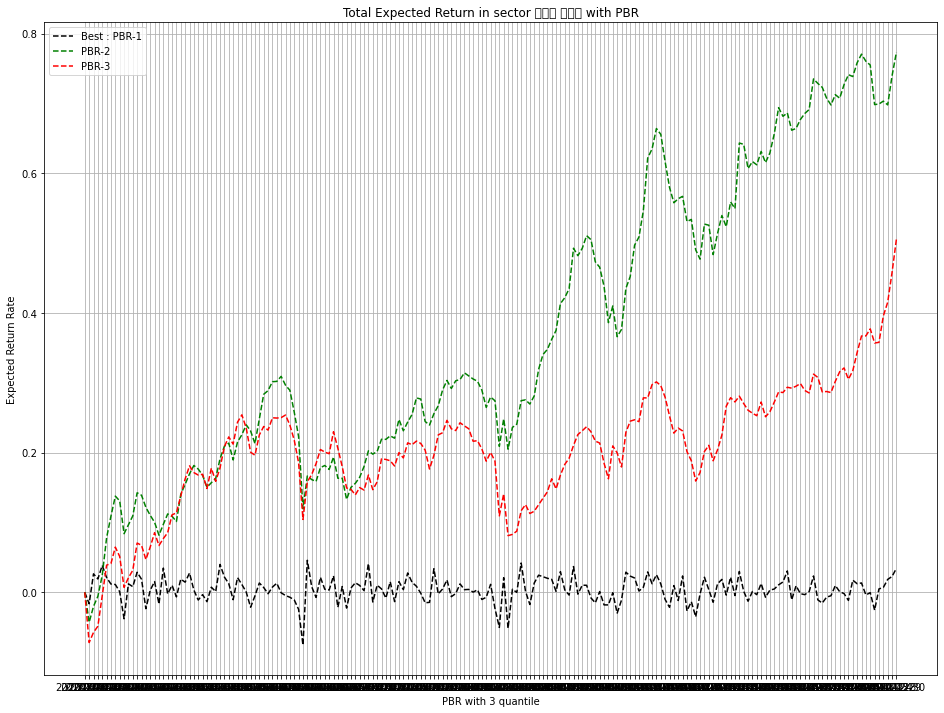

반도체 제조업 PCR 3-Type2


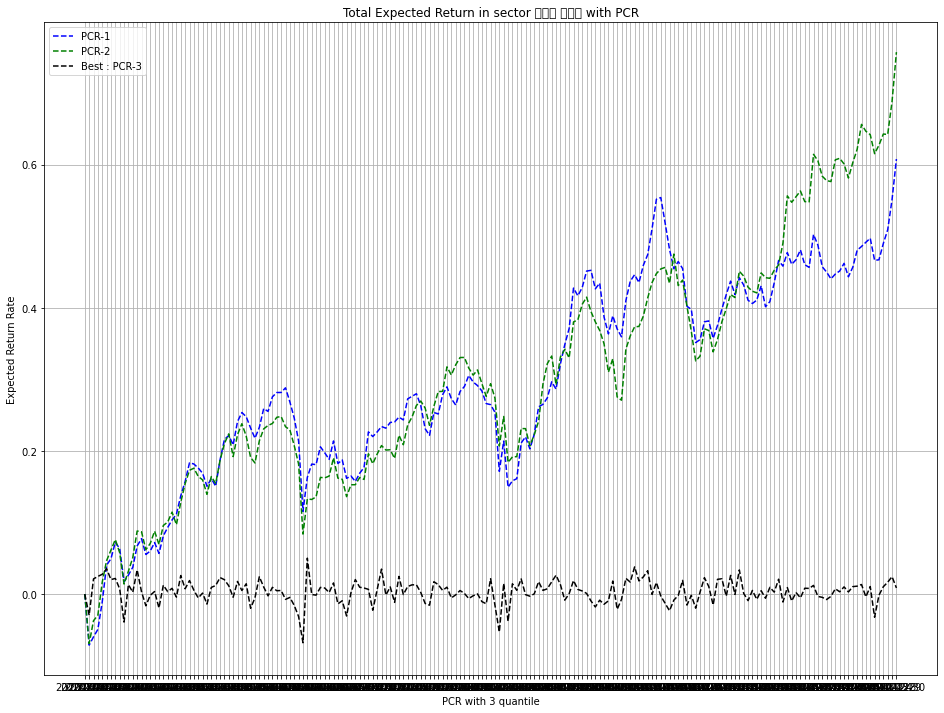

반도체 제조업 POR 3-Type4


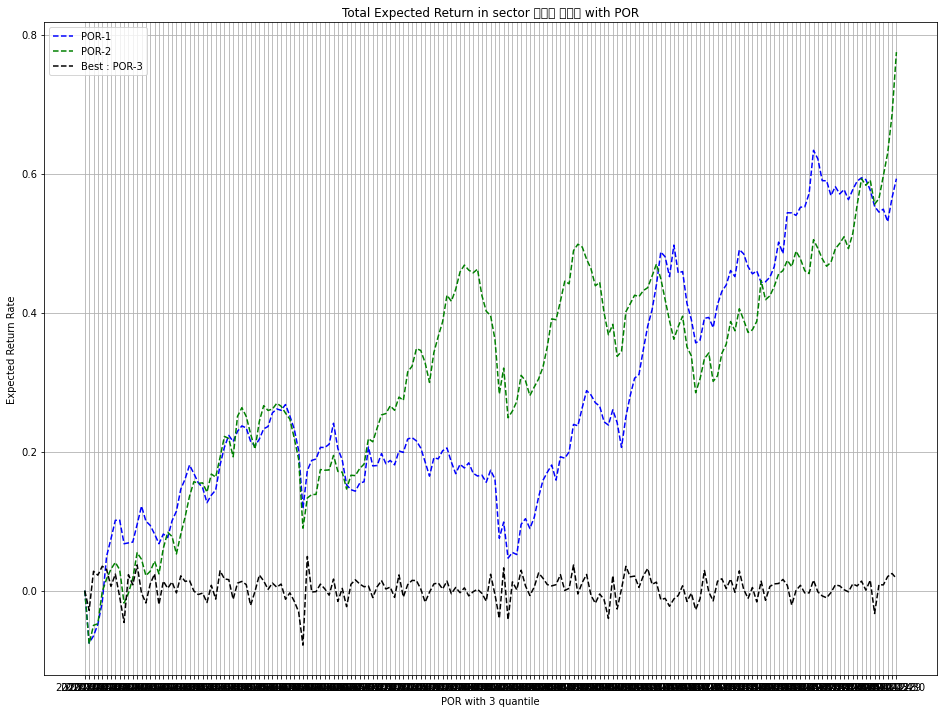

반도체 제조업 PSR 2-Type1


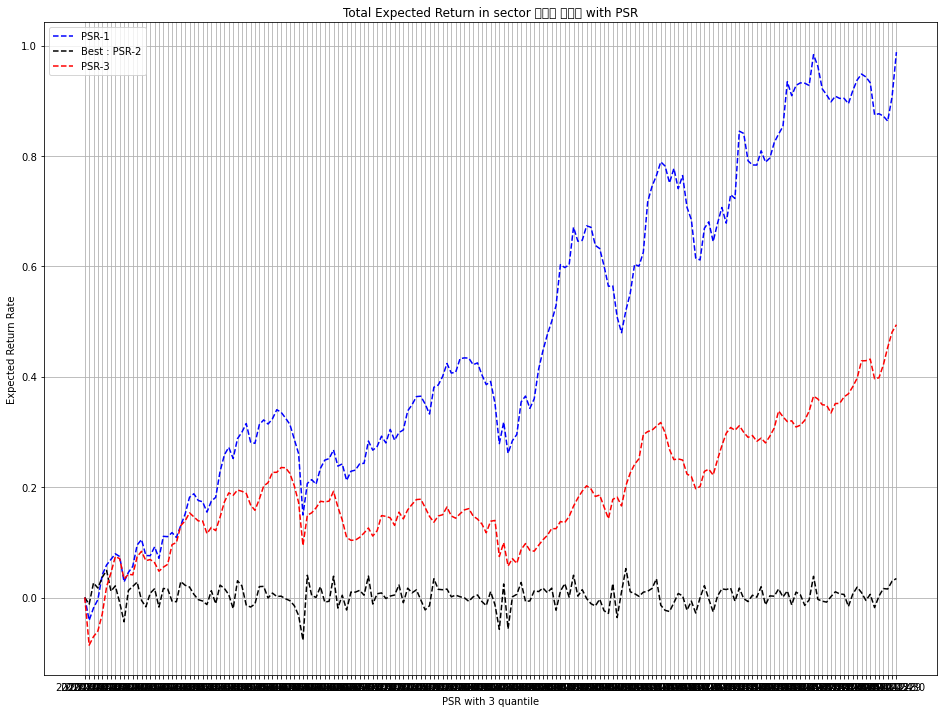

반도체 제조업 PER 3-Type3


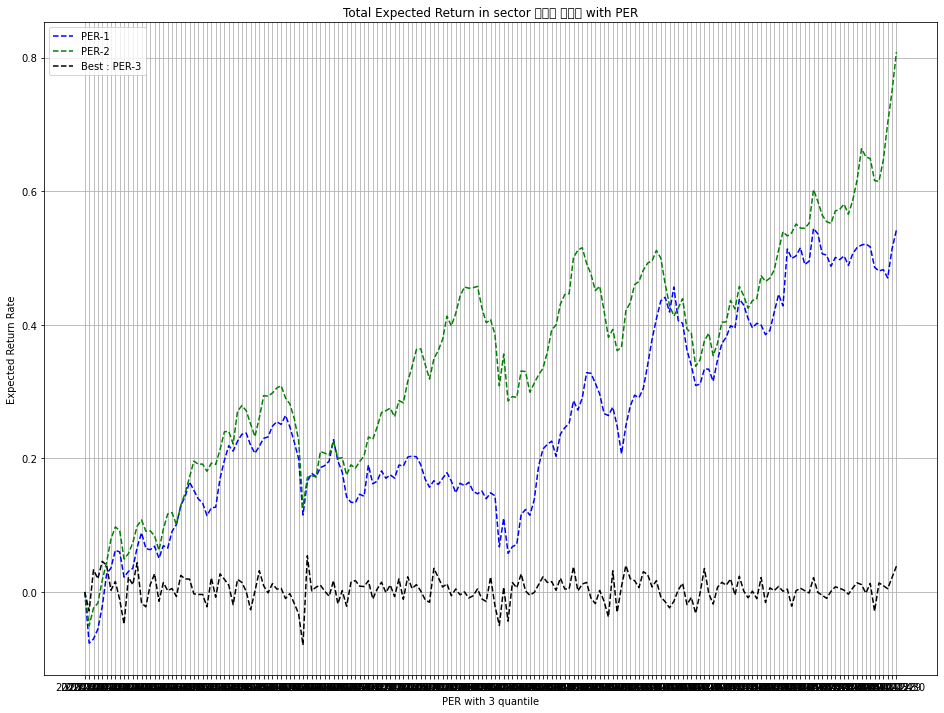

반도체 제조업 EPS 2-Type3


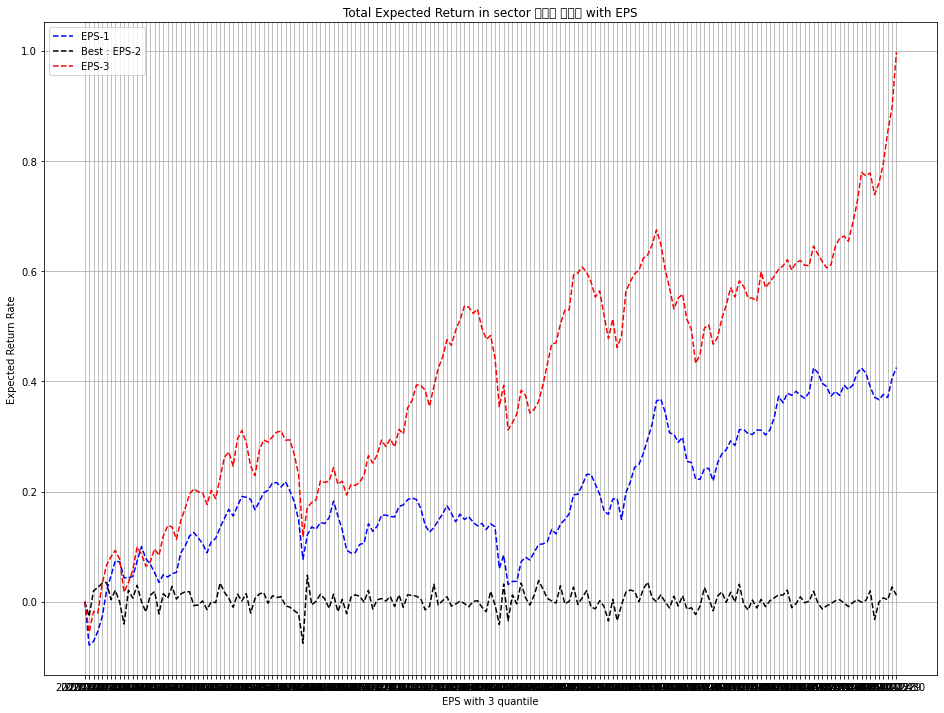

반도체 제조업 BPS 1-Type2


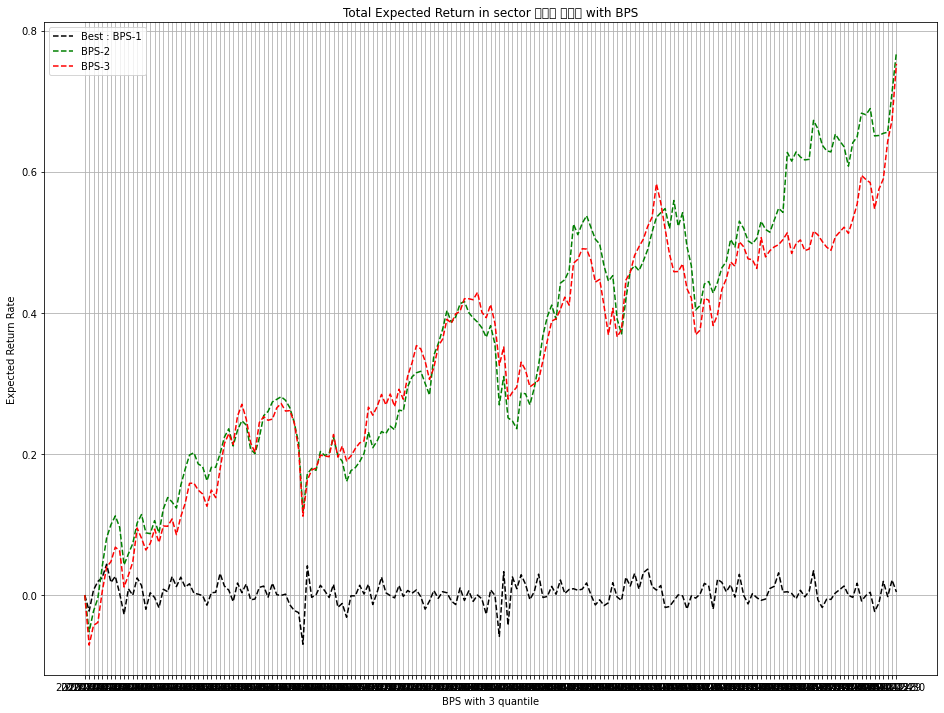

반도체 제조업 ROE 3-Type4


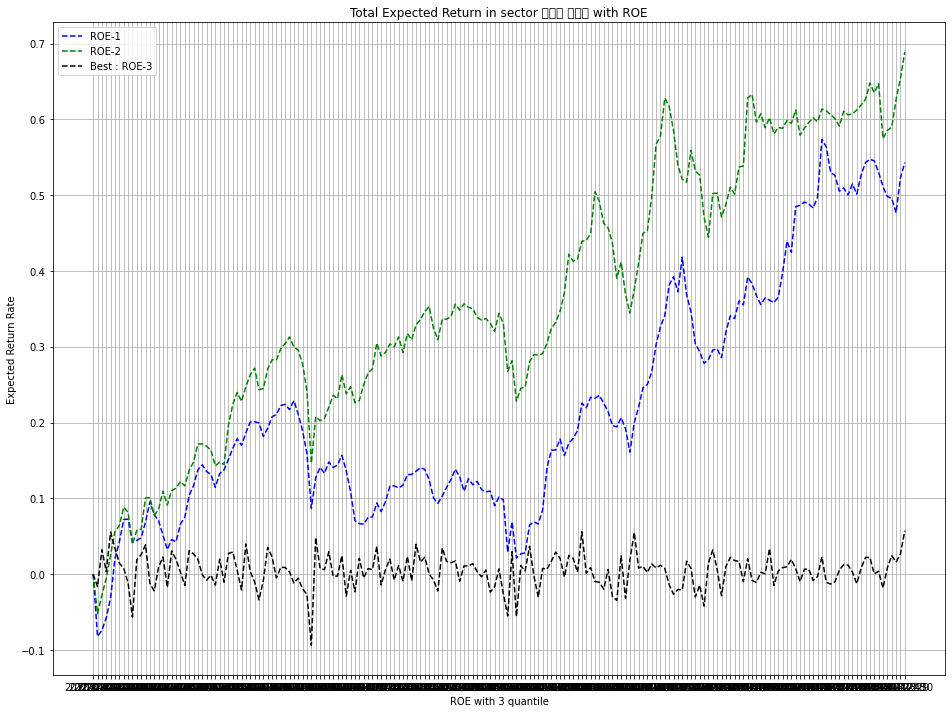

반도체 제조업 ROA 3-Type3


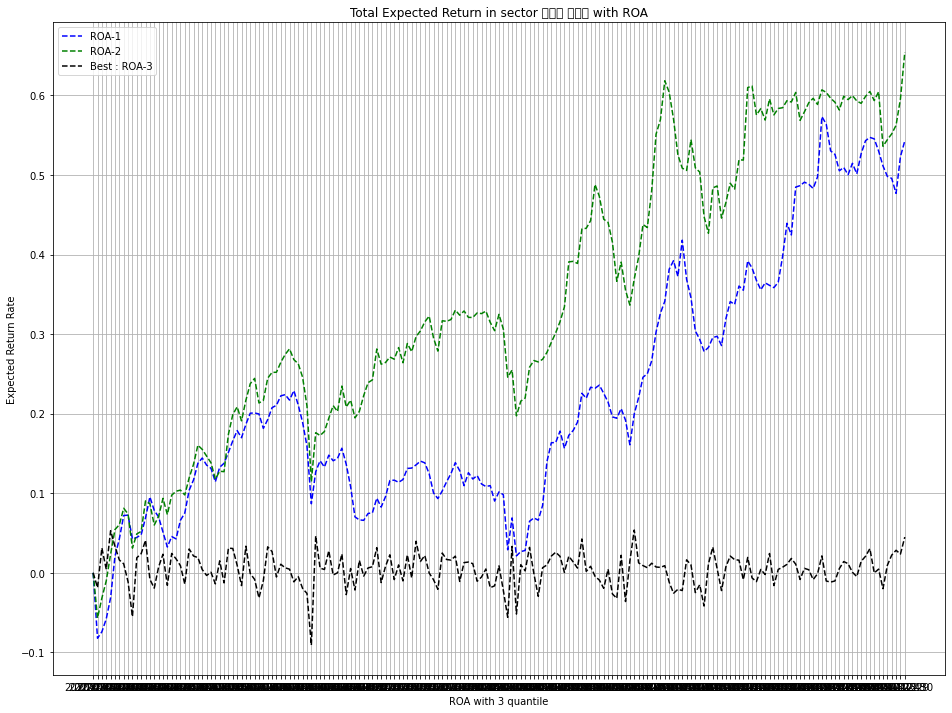

반도체 제조업 시가총액 1-Type2


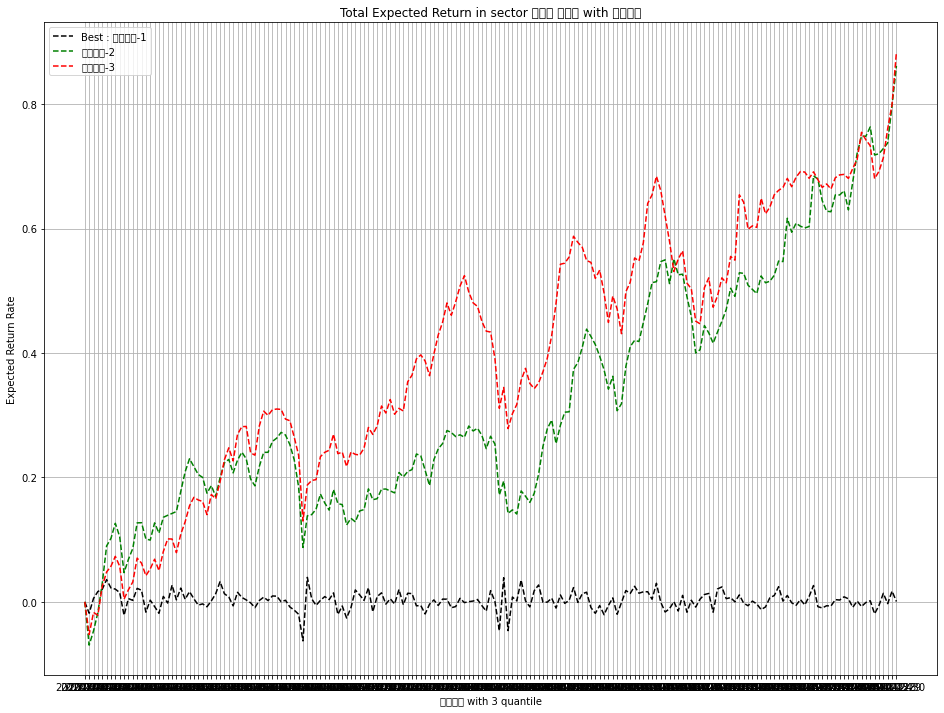

True

In [270]:
dt = '2019-12'
FPVisual(go2[go2.index.isin(['반도체 제조업'])], sc2019, dt)

In [281]:
resec[(resec['Funda'].isin(['시가총액']))&(resec.Date=='2019-12')&(resec.index.isin(['반도체 제조업']))]

Date Funda Pattern C31-Best     C31-Count C32-Best     C32-Count  \
반도체 제조업  2019-12  시가총액       Y        1  [170, 4, 13]        1  [170, 5, 12]   

        C33-Best        C33-Count  
반도체 제조업        3  [187, 184, 187]

In [ ]:
def zz(FP, sc_df, dt):
    start = str(int(dt[:4])+1)+'-03-31'
    if dt != '2019-12':
        end = str(int(dt[:4])+2)+'-02-28'
    else :
        end = '2020-12-31'
    for sc in list(FP.index):
        sc_dict = FP.loc[sc,:].dropna(axis=0).to_dict()
        if len(sc_dict)==0:
            continue
        else :
            for sc_key in sc_dict.keys():
                BestQuantile = sc_dict[sc_key].split('-')[0]
                color=iter(cm.rainbow(np.linspace(0,1,3)))
                plt.figure(figsize=(16,12))
                print(sc, sc_key, sc_dict[sc_key])
                #plt.title("Total Expected Return in sector {} with {}".format(sc,sc_key))
                #plt.xlabel(f"{sc_key} with 3 quantile")
                #plt.ylabel('Expected Return Rate')
                for ith in [1,2,3]:
                    if str(ith) == BestQuantile :
                        sc_idx = sc_df[sc_df.index.isin([sc])&(sc_df['FD-Q']==sc_key+'-'+str(ith))]['Codes'].values[0]
                        pr = ldr.GetPrice(start, end, sc_idx, item='adjprice',colname='code')
                        #print('shape of origin pr : ',pr.shape)
                        pr = pr.dropna(axis=1, how='any')
                        #print('shape of non-nan pr : ',pr.shape)
                        mean_er = GetExpectedReturn_v2(pr,False).T.mean()
                        #c = next(color)
                        #plt.plot(list(mean_er.index), mean_er.values, color='black', linestyle='--', label='Best : {}'.format(sc_key+'-'+str(ith)))
                    else :
                        sc_idx = sc_df[sc_df.index.isin([sc])&(sc_df['FD-Q']==sc_key+'-'+str(ith))]['Codes'].values[0]
                        pr = ldr.GetPrice(start, end, sc_idx, item='adjprice',colname='code')
                        #print('shape of origin pr : ',pr.shape)
                        pr = pr.dropna(axis=1, how='any')
                        #print('shape of non-nan pr : ',pr.shape)
                        mean_er = GetExpectedReturn_v2(pr,True).T.mean()
                        c = ['b','g','r'][ith-1]
                        #plt.plot(list(mean_er.index), mean_er.values, color=c, linestyle='--', label=sc_key+'-'+str(ith))
                
                #plt.legend(loc='upper left')
                #plt.grid(True)
                #plt.show()
                        
    return True

In [284]:
resec

Date Funda Pattern C31-Best      C31-Count C32-Best  \
기초 화학물질 제조업     2016-12   PBR       N        2  [1, 121, 100]        3   
기초 화학물질 제조업     2016-12   PCR       Y        1  [176, 18, 28]        1   
기초 화학물질 제조업     2016-12   POR       Y        1  [102, 63, 57]        1   
기초 화학물질 제조업     2016-12   PSR       Y        2  [21, 119, 82]        2   
기초 화학물질 제조업     2016-12   PER       Y        1  [171, 35, 16]        1   
...                 ...   ...     ...      ...            ...      ...   
기타 금속 가공제품 제조업  2019-12   EPS       Y        3   [5, 11, 171]        3   
기타 금속 가공제품 제조업  2019-12   BPS       Y        1   [152, 27, 8]        1   
기타 금속 가공제품 제조업  2019-12   ROE       Y        3    [1, 0, 186]        3   
기타 금속 가공제품 제조업  2019-12   ROA       Y        3    [1, 0, 186]        3   
기타 금속 가공제품 제조업  2019-12  시가총액       Y        1   [170, 4, 13]        1   

                    C32-Count C33-Best        C33-Count  
기초 화학물질 제조업     [1, 109, 112]        3  [167, 222, 222]  
기초 화학물질 제조업     [172, 20, 30]        3  [222, 215, 222]  
기초 화학물질 제조업     [111, 54, 57]        3  [220, 222, 222]  
기초 화학물질 제조업     [19, 120, 83]        3  [220, 222, 222]  
기초 화학물질 제조업     [170, 30, 22]        3  [222, 222, 222]  
...                       ...      ...              ...  
기타 금속 가공제품 제조업    [9, 9, 169]        3  [187, 187, 187]  
기타 금속 가공제품 제조업   [166, 14, 7]        3  [187, 187, 187]  
기타 금속 가공제품 제조업    [1, 2, 184]        3  [184, 187, 187]  
기타 금속 가공제품 제조업    [1, 0, 186]        3  [184, 187, 187]  
기타 금속 가공제품 제조업   [170, 5, 12]        3  [187, 184, 187]  

[1080 rows x 9 columns]

In [285]:
sc2019[(sc2019.index.isin(['반도체 제조업']))&(sc2019['FD-Q'].isin(['시가총액-1','시가총액-2','시가총액-3']))]

FD-Q  C1     C1(%) C1(T) C2-GMean C2-MeanCodes  C2-Mean  \
반도체 제조업  시가총액-2  17         1    17  1.19806          NaN  1.33378   
반도체 제조업  시가총액-3  16  0.941176    17  1.05845          NaN  1.40973   
반도체 제조업  시가총액-1  12  0.666667    18  1.40537          NaN  1.24264   

                                                     Codes  
반도체 제조업  [004770, 017900, 020760, 033170, 038060, 05286...  
반도체 제조업  [000660, 000990, 011690, 011930, 033640, 03654...  
반도체 제조업  [032580, 043590, 059120, 062860, 064520, 06569...

In [288]:
ss1 = sc2019[(sc2019.index.isin(['반도체 제조업']))&(sc2019['FD-Q'].isin(['시가총액-1']))].Codes.values[0]
ss2 = sc2019[(sc2019.index.isin(['반도체 제조업']))&(sc2019['FD-Q'].isin(['시가총액-2']))].Codes.values[0]
ss3 = sc2019[(sc2019.index.isin(['반도체 제조업']))&(sc2019['FD-Q'].isin(['시가총액-3']))].Codes.values[0]

In [307]:
pr1 = ldr.GetPrice('2020-03-31', '2020-12-31', ss1, item='adjprice',colname='code')
pr1 = pr1.dropna(axis=1, how='any')
mean_er1 = GetExpectedReturn_v2(pr1,True).T.mean()

In [308]:
pr2 = ldr.GetPrice('2020-03-31', '2020-12-31', ss2, item='adjprice',colname='code')
pr2 = pr2.dropna(axis=1, how='any')
mean_er2 = GetExpectedReturn_v2(pr2,True).T.mean()

In [309]:
pr3 = ldr.GetPrice('2020-03-31', '2020-12-31', ss3, item='adjprice',colname='code')
pr3 = pr3.dropna(axis=1, how='any')
mean_er3 = GetExpectedReturn_v2(pr3,True).T.mean()

In [310]:
t1 = pd.DataFrame(mean_er1, columns=['Q1'])
t2 = pd.DataFrame(mean_er2, columns=['Q2'])
t3 = pd.DataFrame(mean_er3, columns=['Q3'])

In [305]:
pr1.shape

(187, 18)

In [317]:
tt = pd.concat([t1,t2,t3],axis=1)

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(t1.index, t1['Q1'], label='Q1')
plt.plot(t1.index, t2['Q2'], label='Q2')
plt.plot(t1.index, t3['Q3'], label='Q3')
plt.legend(loc='upper left')

In [319]:
tt

Q1        Q2        Q3
2020-03-31  0.000000  0.000000  0.000000
2020-04-01 -0.056945 -0.069558 -0.052506
2020-04-02 -0.051784 -0.046788 -0.016944
2020-04-03 -0.035144 -0.017038 -0.021472
2020-04-06 -0.016262  0.029705  0.025174
...              ...       ...       ...
2020-12-23  0.364216  0.720454  0.691965
2020-12-24  0.379218  0.728665  0.713813
2020-12-28  0.372024  0.737672  0.760547
2020-12-29  0.399568  0.798362  0.799695
2020-12-30  0.403761  0.861583  0.883689

[187 rows x 3 columns]

In [299]:
a = b = c = 0
for d in list(tt.index):
    idx = tt.loc[d].idxmax()
    if idx == 'Q1': a+=1
    elif idx == 'Q2' : b+=1
    elif idx == 'Q3' : c+=1
    else : raise ValueError("Can't be !!!")
var = {a:'Q1', b:'Q2', c:'Q3'}

In [300]:
a, b, c

(57, 63, 67)

In [324]:
var.get(max(var))

'Q3'

In [302]:
resec[(resec.index.isin(['반도체 제조업']))&(resec.Funda.isin(['PBR']))]

Date Funda Pattern C31-Best      C31-Count C32-Best  \
반도체 제조업  2016-12   PBR       N        2  [1, 121, 100]        3   
반도체 제조업  2017-12   PBR       Y        1  [111, 1, 110]        1   
반도체 제조업  2018-12   PBR       Y        1  [133, 10, 84]        1   
반도체 제조업  2019-12   PBR       Y        2   [3, 166, 18]        2   

             C32-Count C33-Best        C33-Count  
반도체 제조업  [1, 109, 112]        3  [167, 222, 222]  
반도체 제조업  [119, 2, 101]        1    [103, 50, 82]  
반도체 제조업   [144, 9, 74]        1  [223, 116, 214]  
반도체 제조업   [5, 142, 40]        2  [186, 187, 184]

In [303]:
57+63+67

187

In [304]:
3+166+18

187

In [321]:
dfs = [sc2016,sc2017,sc2018,sc2019]

In [323]:
len(set(resec.index))

29

In [27]:
def FinalFundaER(dfs, sc_df):
    #dfs = [sc2016, sc2017, sc2018, sc2019]
    sc_ls = list(set(sc_df.index))
    year = 2016
    total = pd.DataFrame()
    errs = []
    for df in dfs :
        start = str(year+1)+'-03-31'
        if year != 2019:
            end = str(year+2)+'-02-28'
        else :
            end = '2020-12-31'
        for sc in sc_ls:
            for fd in ['PBR','PCR','POR','PSR','PER','EPS','BPS','ROE','ROA','시가총액']:
                try :
                    tmp = pd.DataFrame(index=[sc], columns=['Date','Funda','C31-Best','C31-Count'])
                    sc_idx1 = df[(df.index.isin([sc]))&(df['FD-Q'].isin([fd+'-1']))].Codes.values[0]
                    sc_idx2 = df[(df.index.isin([sc]))&(df['FD-Q'].isin([fd+'-2']))].Codes.values[0]
                    sc_idx3 = df[(df.index.isin([sc]))&(df['FD-Q'].isin([fd+'-3']))].Codes.values[0]
                    pr1 = ldr.GetPrice(start, end, sc_idx1, item='adjprice',colname='code')
                    pr1 = pr1.dropna(axis=1, how='all')
                    pr1 = pr1.fillna(method='ffill').fillna(method='bfill')
                    mean_er1 = GetExpectedReturn_v2(pr1,True).T.mean()
                    pr2 = ldr.GetPrice(start, end, sc_idx2, item='adjprice',colname='code')
                    pr2 = pr2.dropna(axis=1, how='all')
                    pr2 = pr2.fillna(method='ffill').fillna(method='bfill')
                    mean_er2 = GetExpectedReturn_v2(pr2,True).T.mean()
                    pr3 = ldr.GetPrice(start, end, sc_idx3, item='adjprice',colname='code')
                    pr3 = pr3.dropna(axis=1, how='all')
                    pr3 = pr3.fillna(method='ffill').fillna(method='bfill')
                    mean_er3 = GetExpectedReturn_v2(pr3,True).T.mean()
                    t1 = pd.DataFrame(mean_er1, columns=['Q1'])
                    t2 = pd.DataFrame(mean_er2, columns=['Q2'])
                    t3 = pd.DataFrame(mean_er3, columns=['Q3'])
                    tt = pd.concat([t1,t2,t3],axis=1)


                    a = b = c = 0
                    for d in list(tt.index):
                        idx = tt.loc[d].idxmax()
                        if idx == 'Q1': a+=1
                        elif idx == 'Q2' : b+=1
                        elif idx == 'Q3' : c+=1
                        else : 
                            raise ValueError("Can't be !!!")
                    var = {a:'1', b:'2', c:'3'}

                    if fd == 'PBR' and sc == '기타 화학제품 제조업':
                        plt.figure(figsize=(16,12))
                        plt.title("FD : {} & year : {} & Best : {}".format(fd, year, var.get(max(var))))
                        plt.plot(tt.index, t1['Q1'], label='Q1')
                        plt.plot(tt.index, t2['Q2'], label='Q2')
                        plt.plot(tt.index, t3['Q3'], label='Q3')
                        plt.legend(loc='upper left')
                        plt.grid(True)
                        plt.show()

                    tmp.loc[sc,'Date'] = str(year)+'-12'
                    tmp.loc[sc,'Funda'] = fd
                    tmp.loc[sc,'C31-Best'] = var.get(max(var))
                    tmp.loc[sc,'C31-Count'] = [a,b,c]
                    total = pd.concat([total, tmp])
                except :
                    errs.append(str(year)+'-'+sc+'-'+fd)
        year += 1
    return total

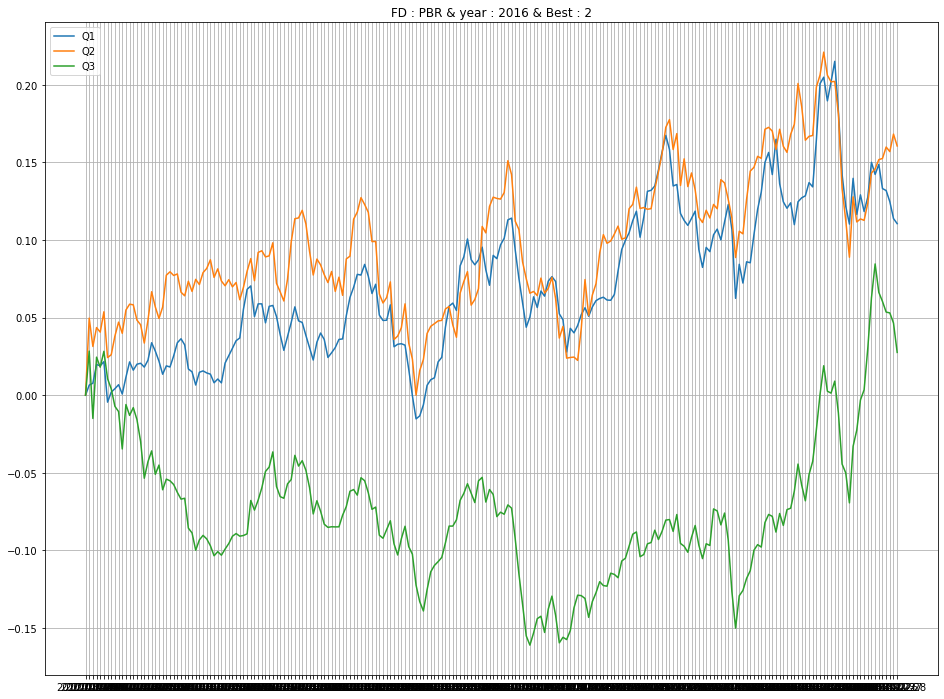

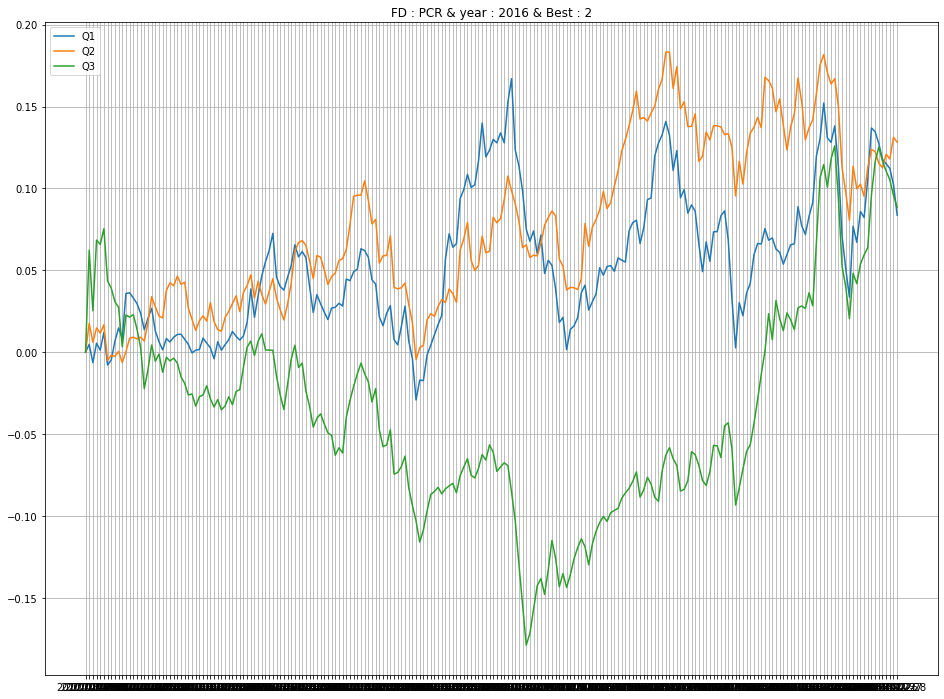

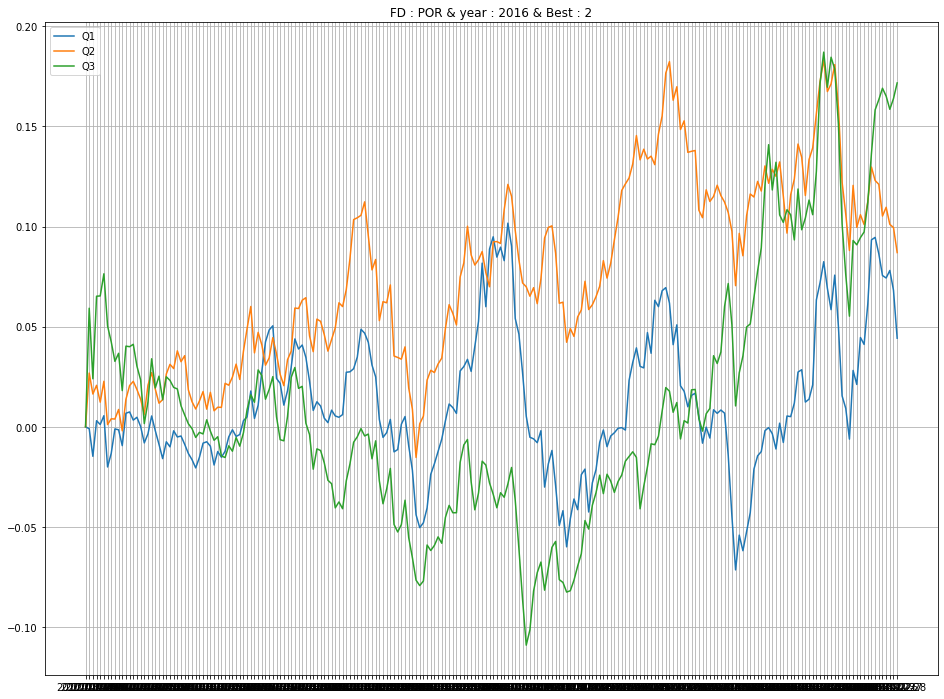

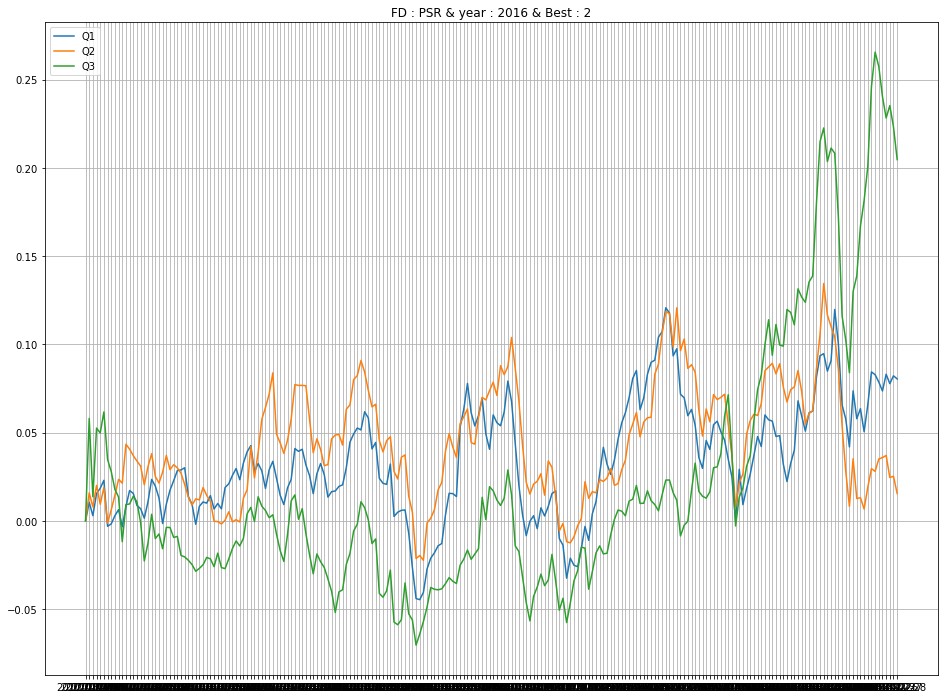

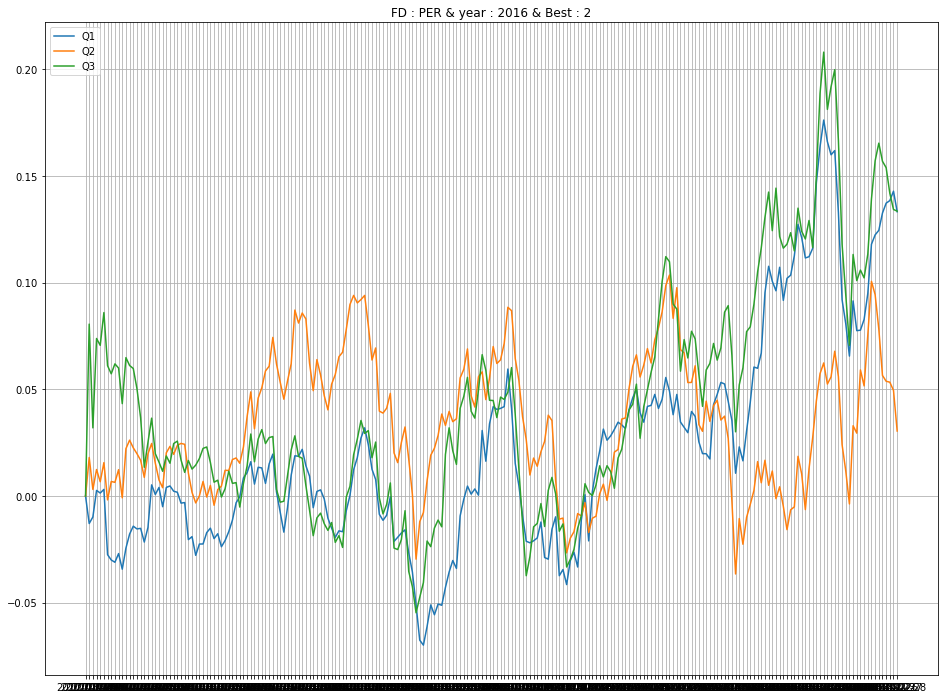

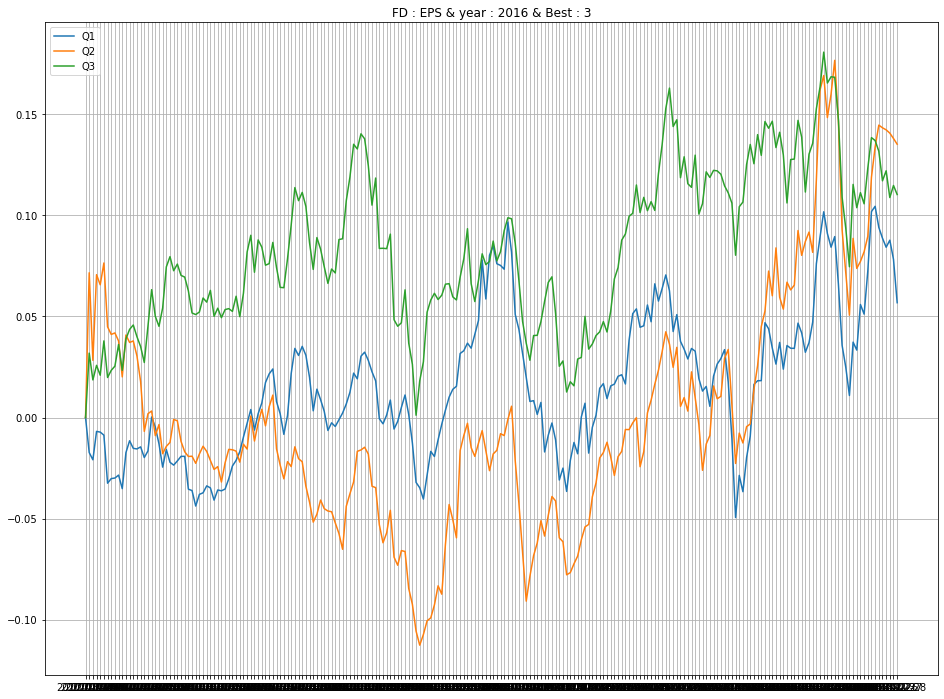

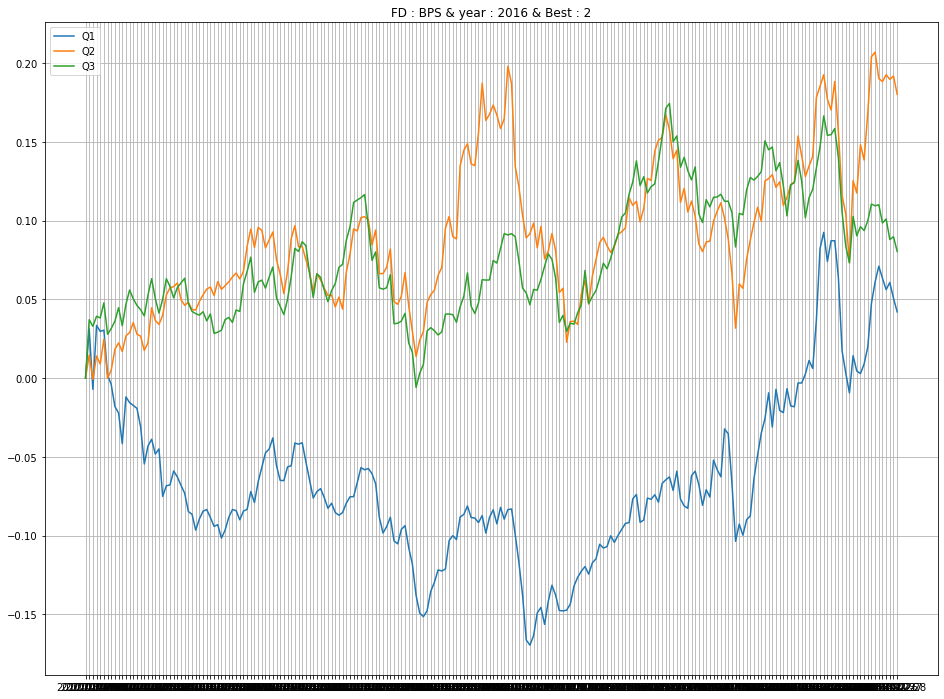

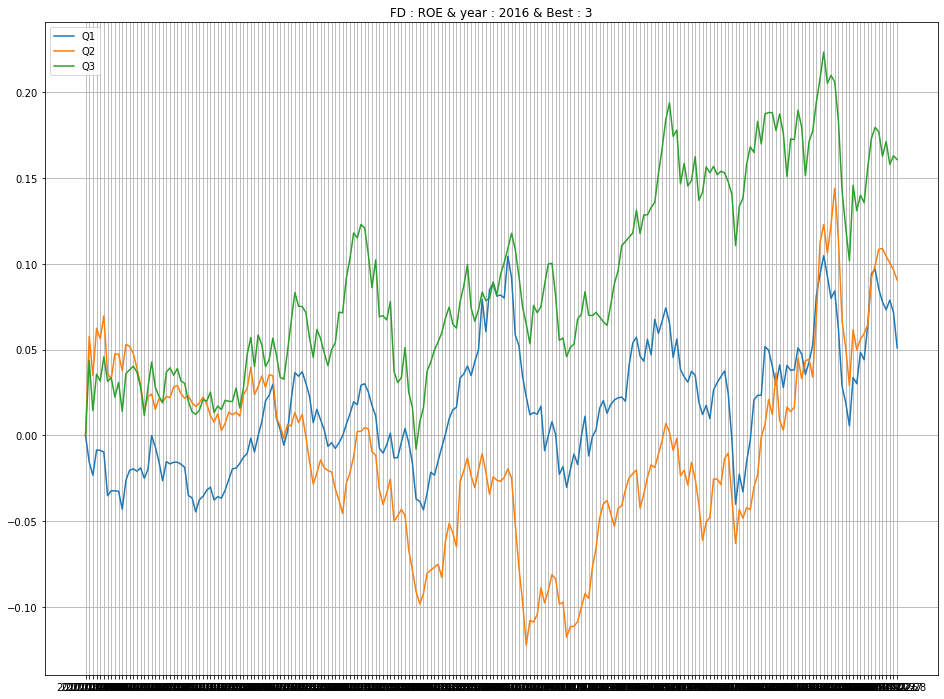

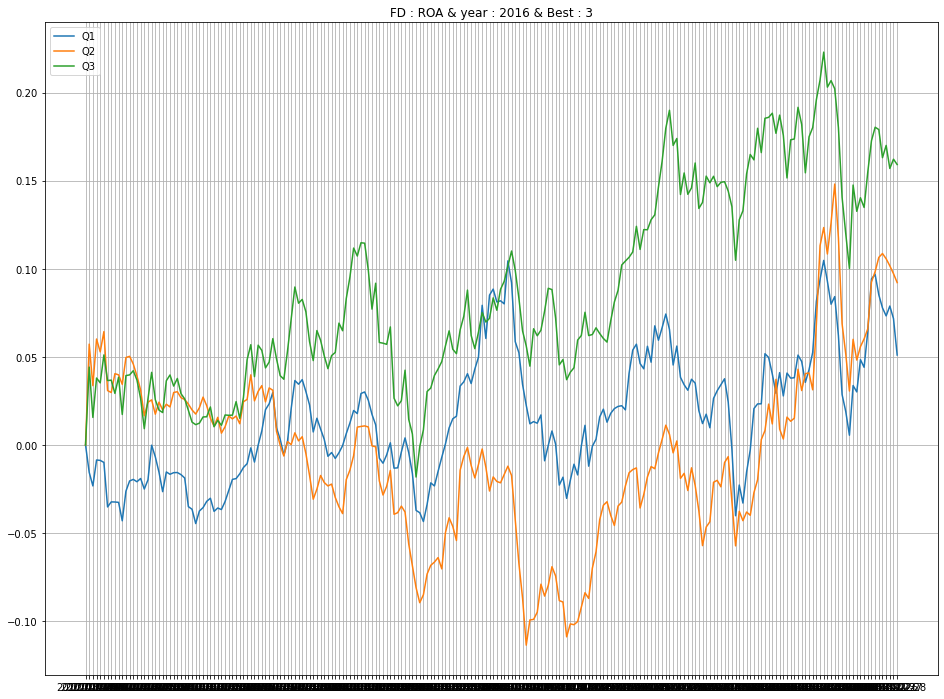

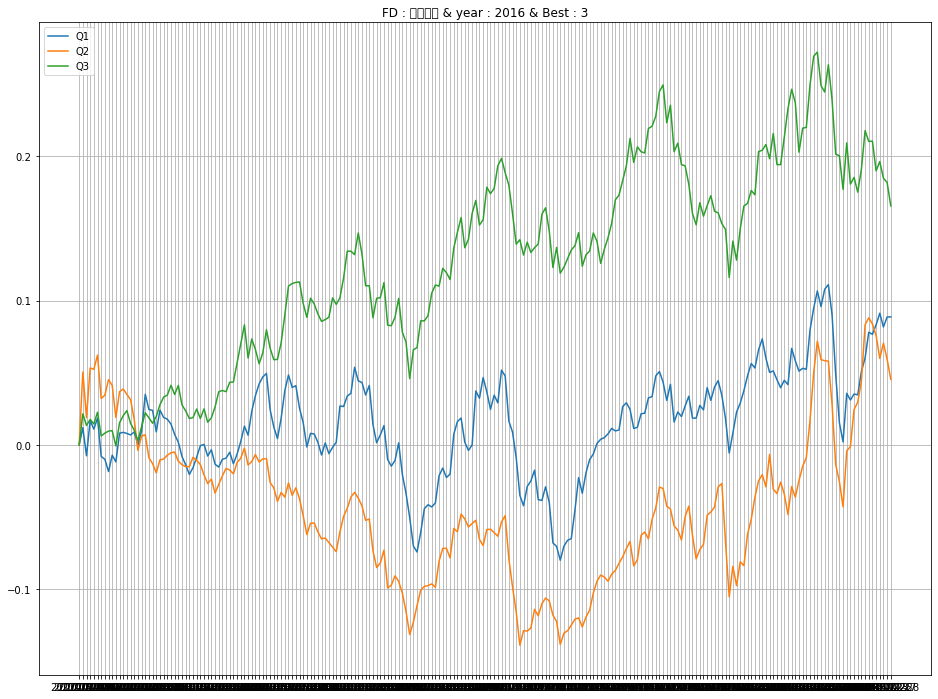

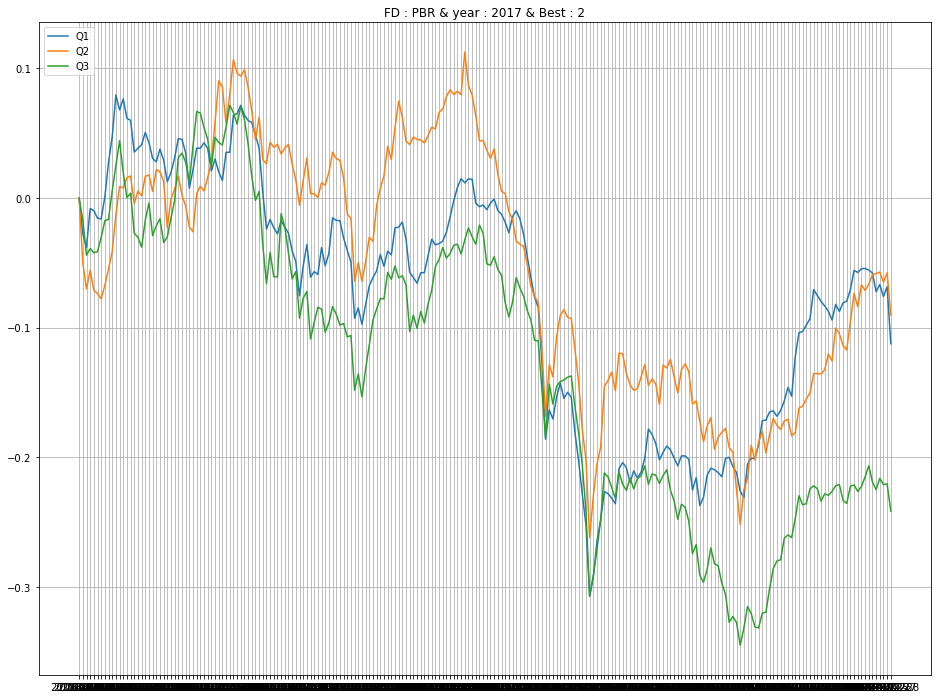

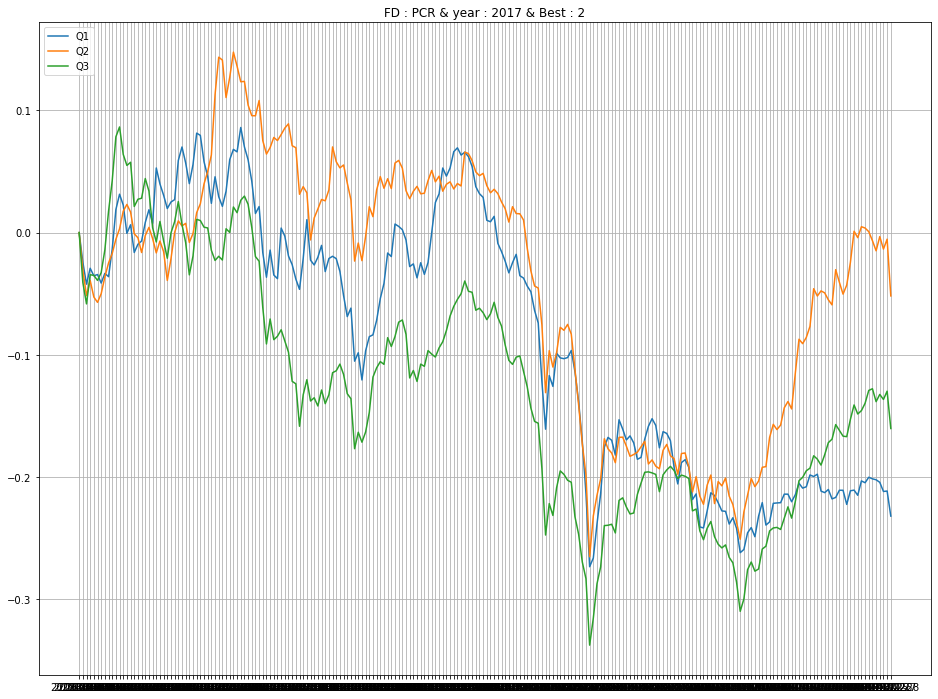

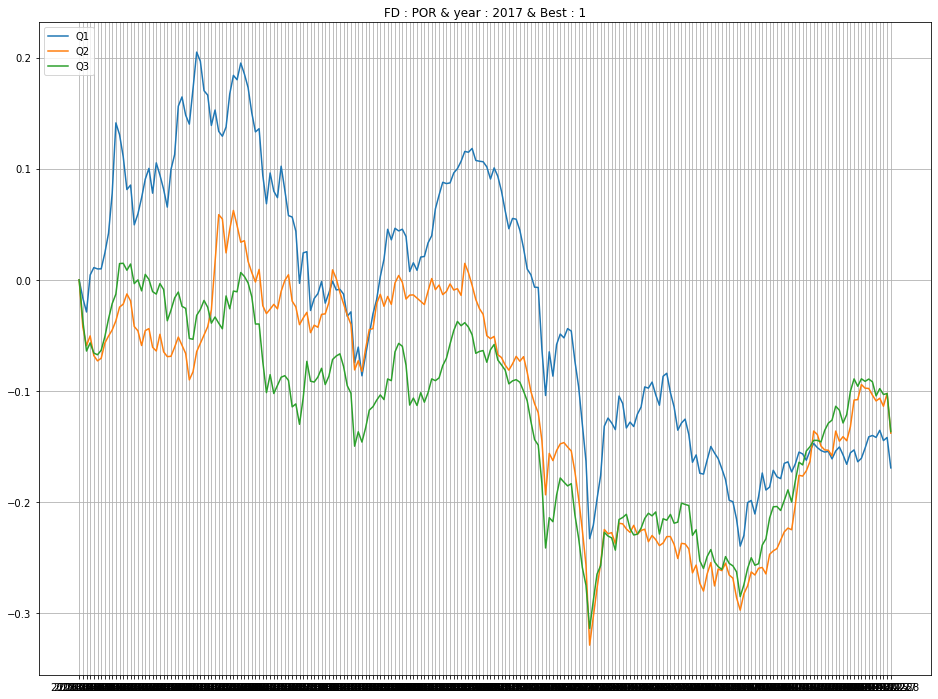

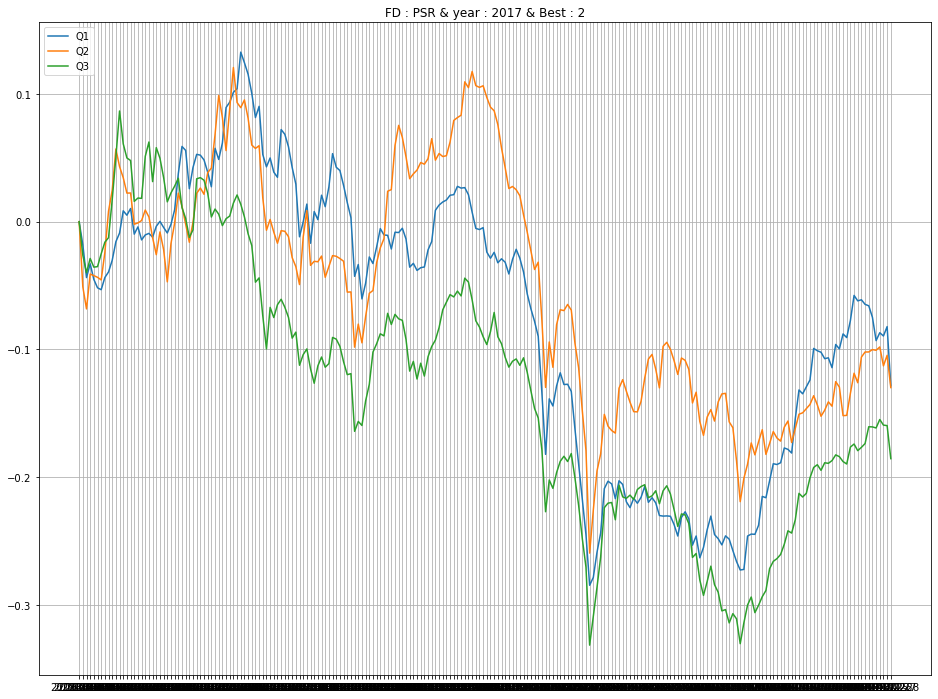

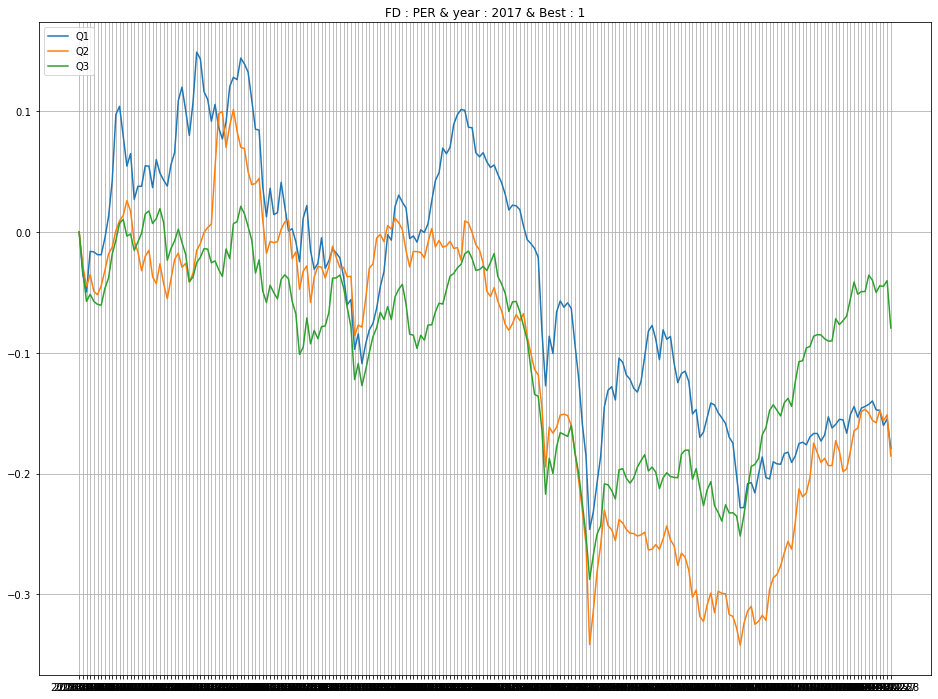

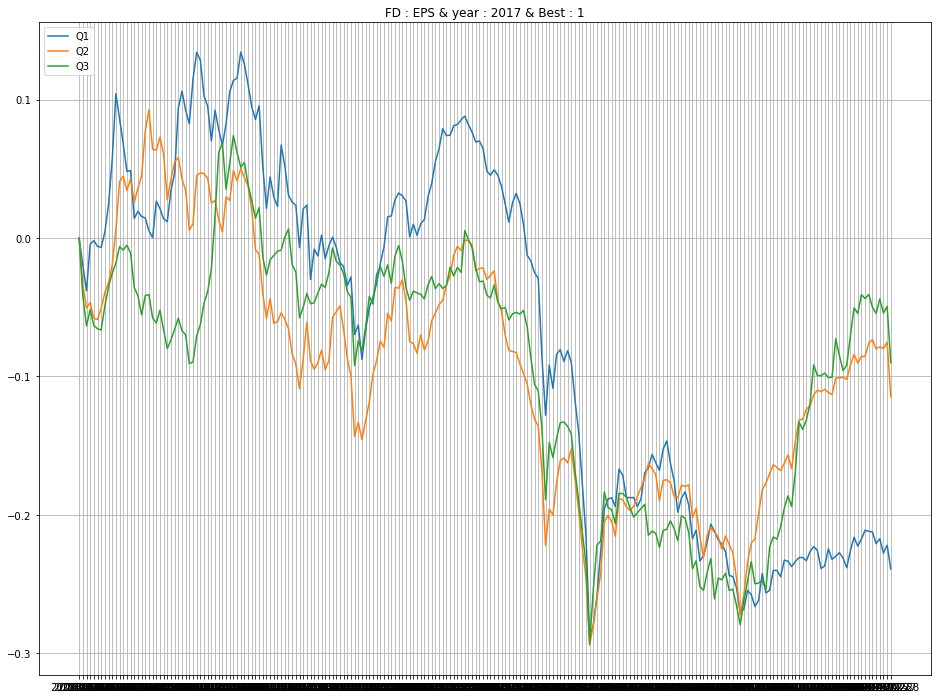

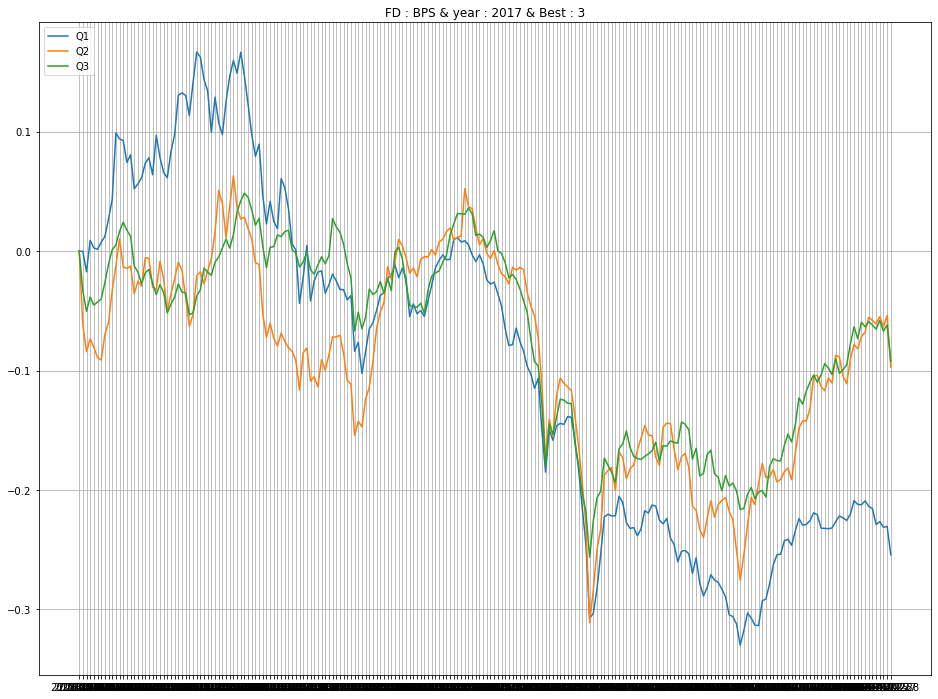

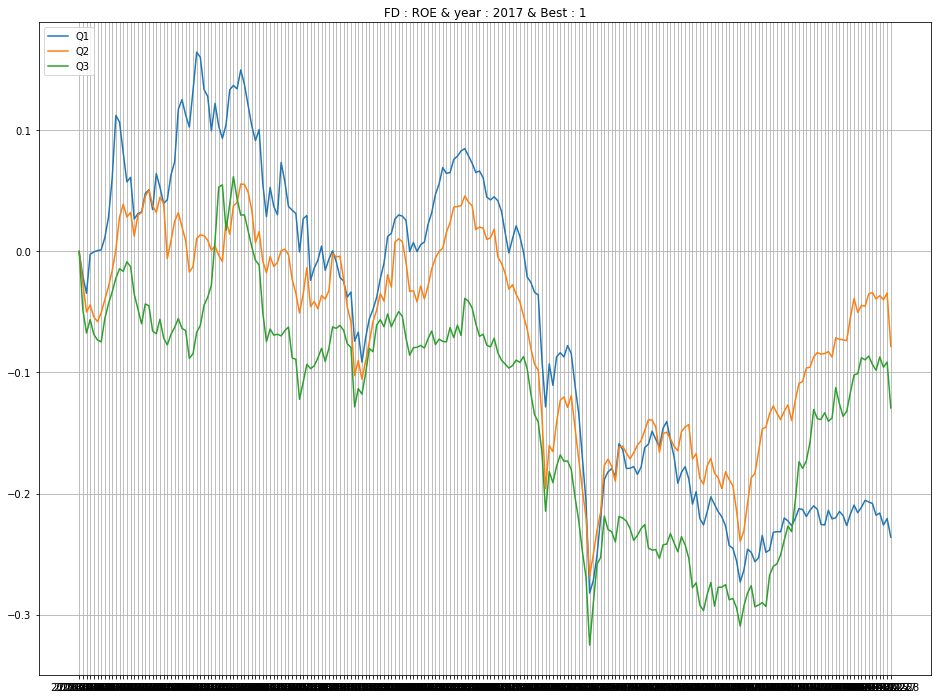

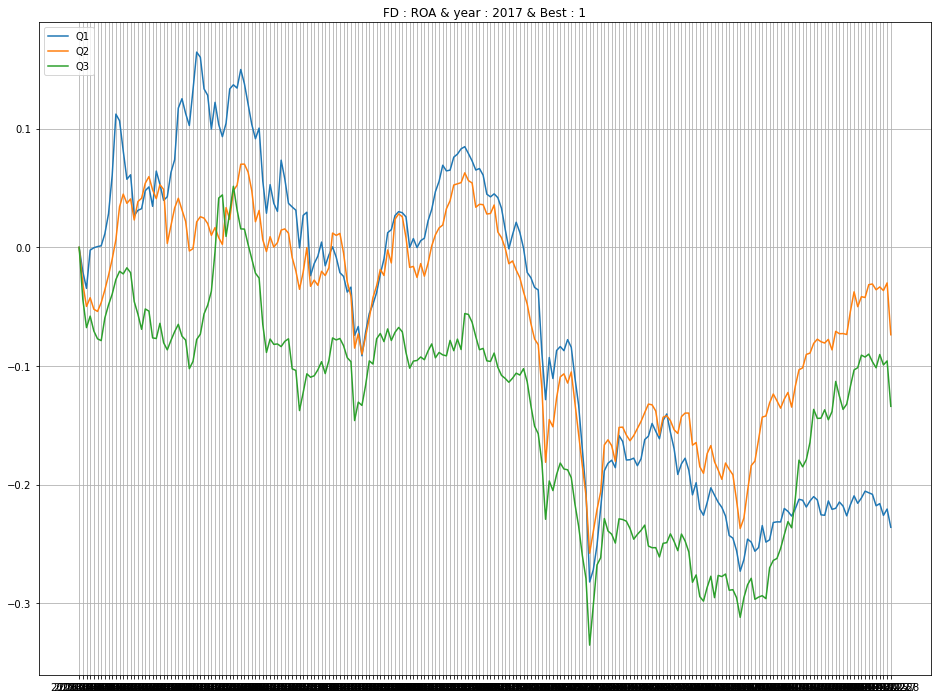

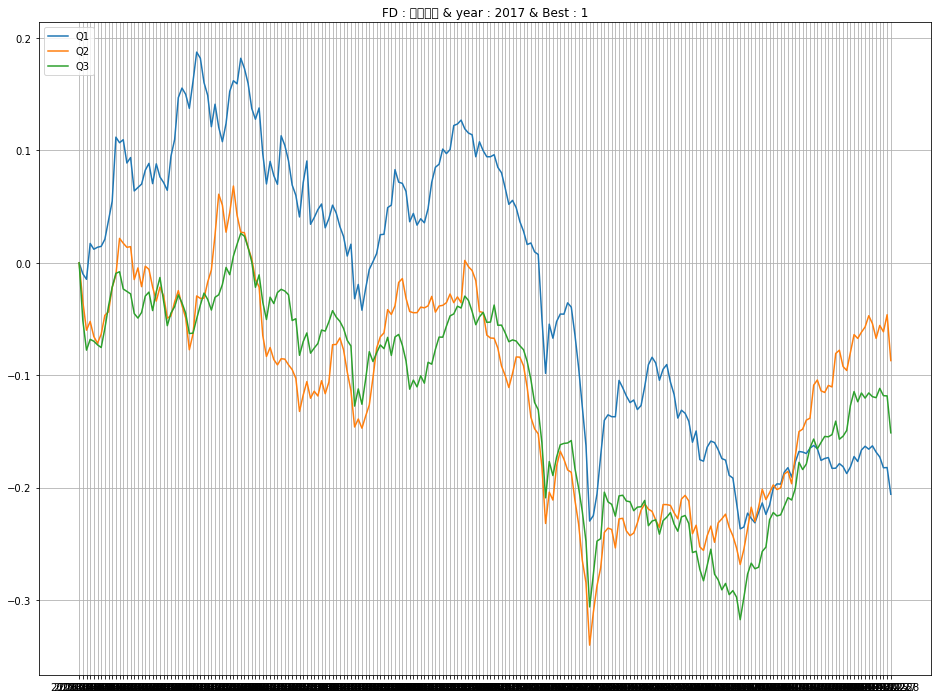

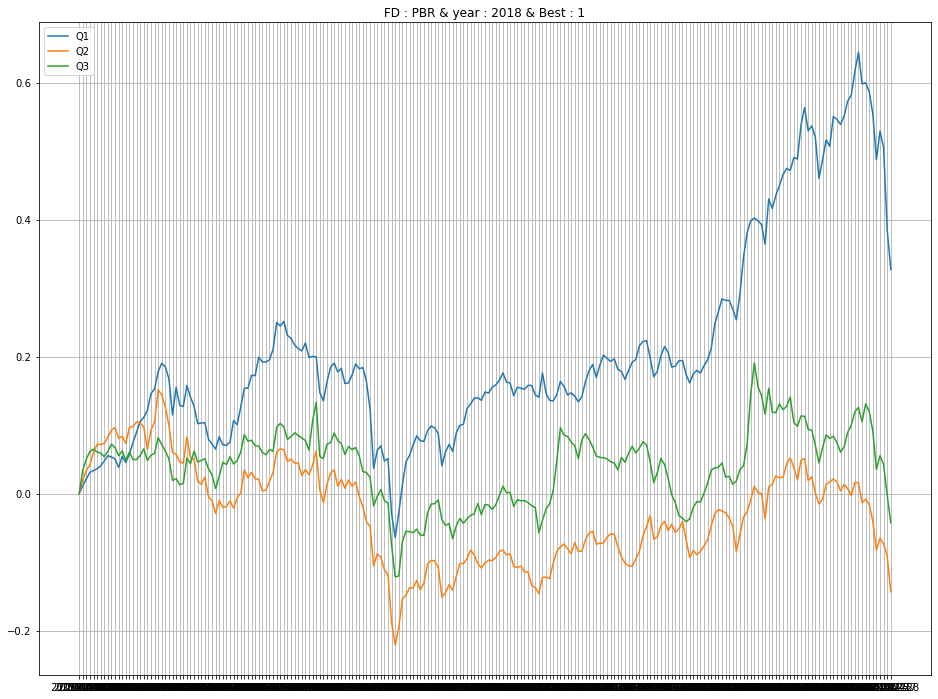

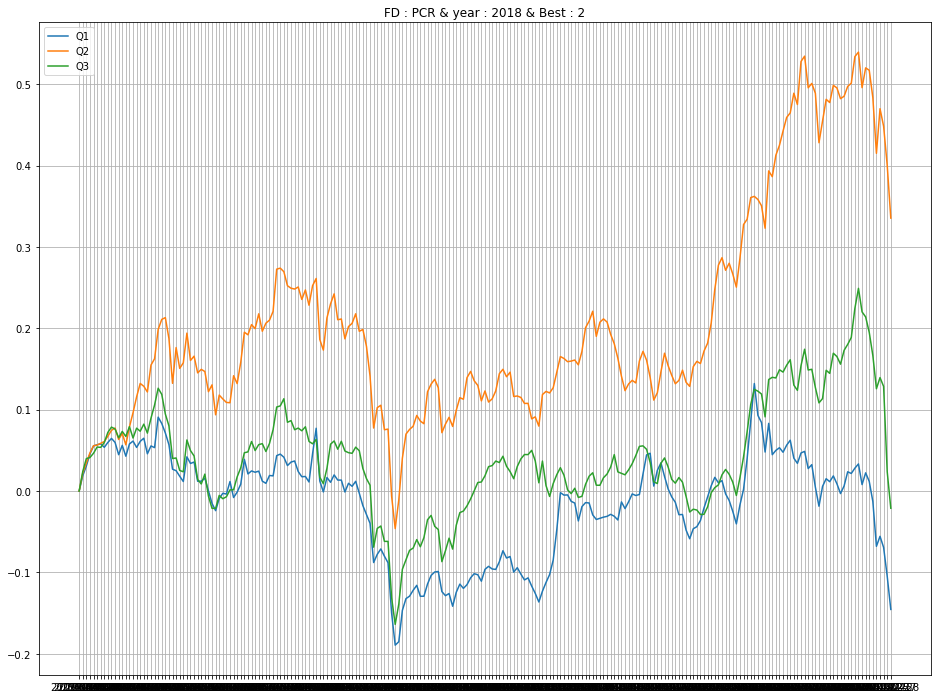

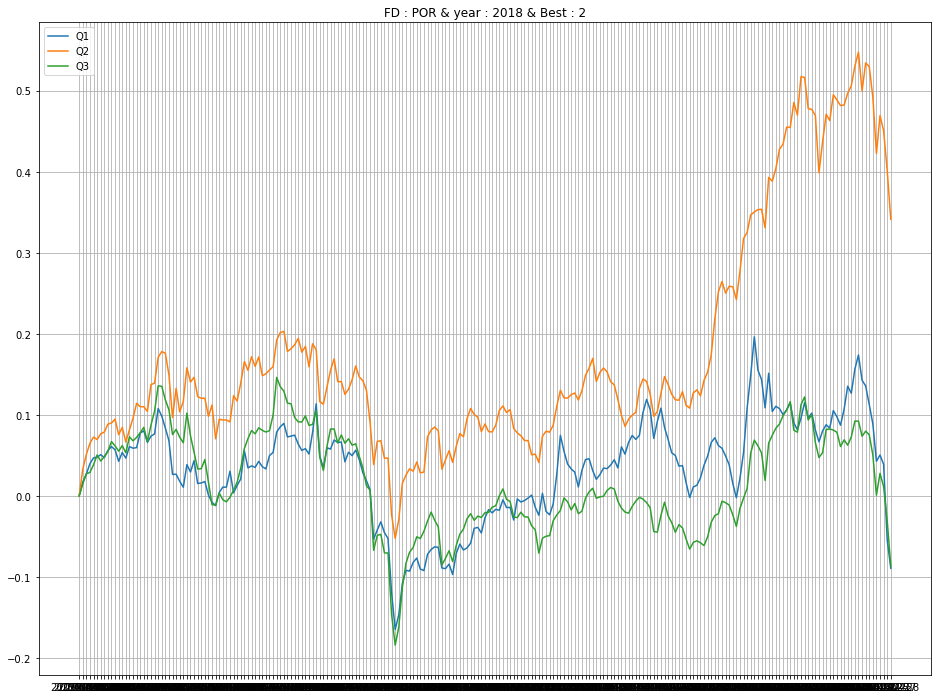

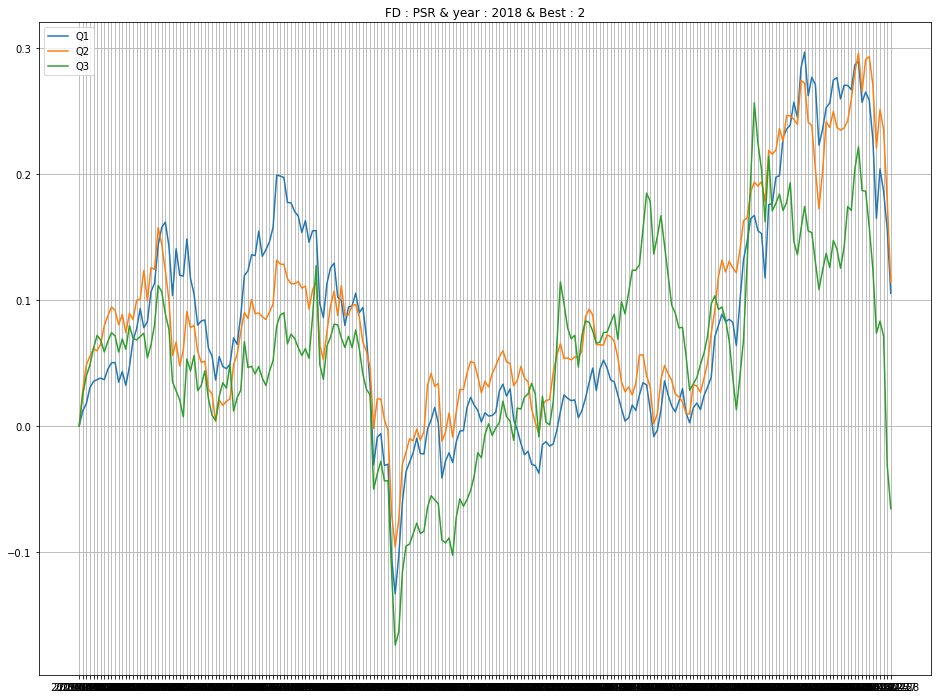

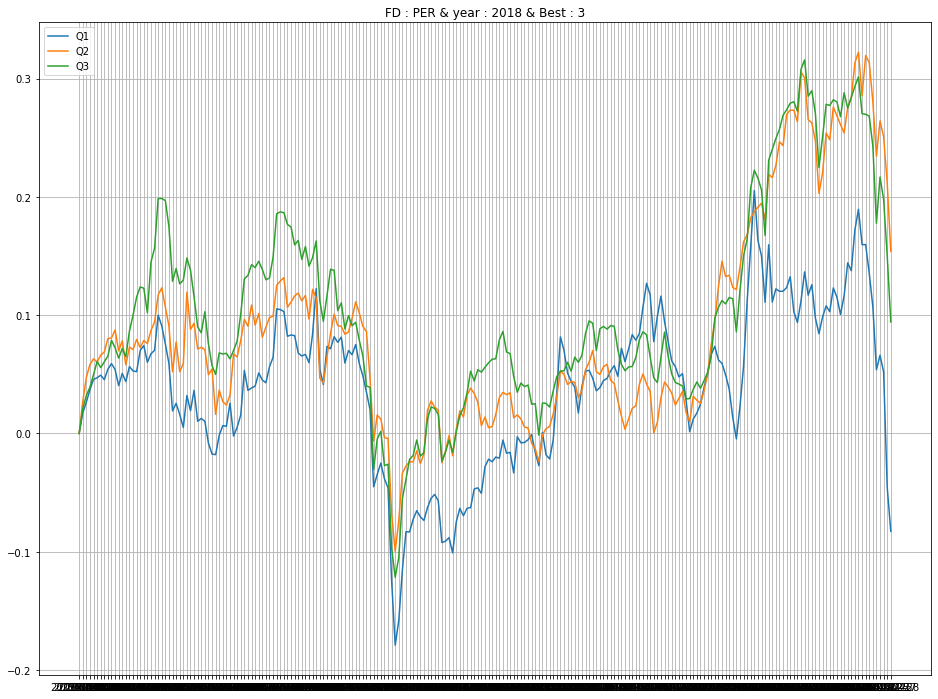

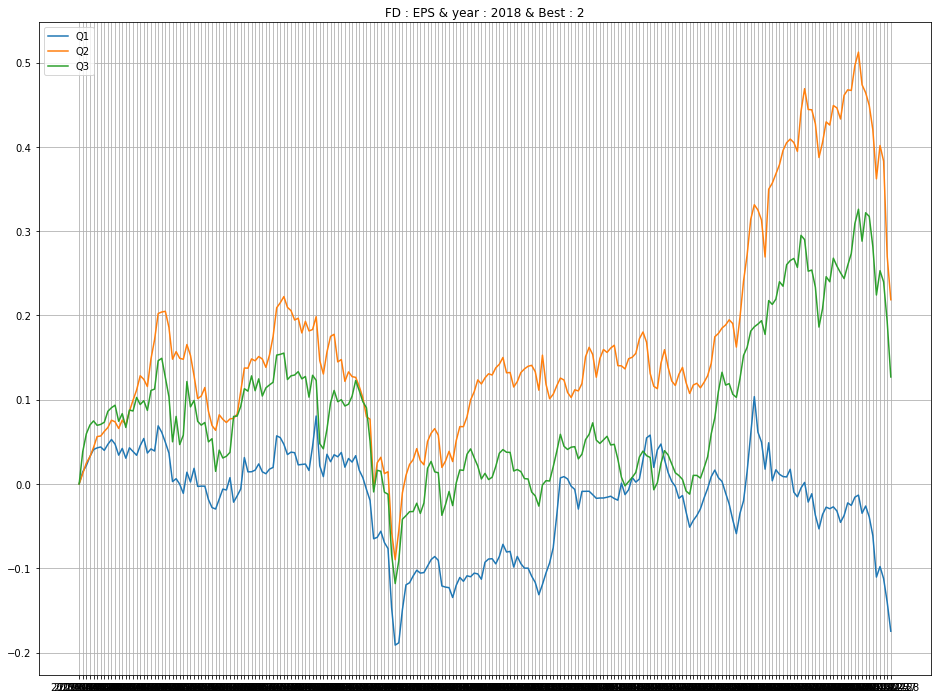

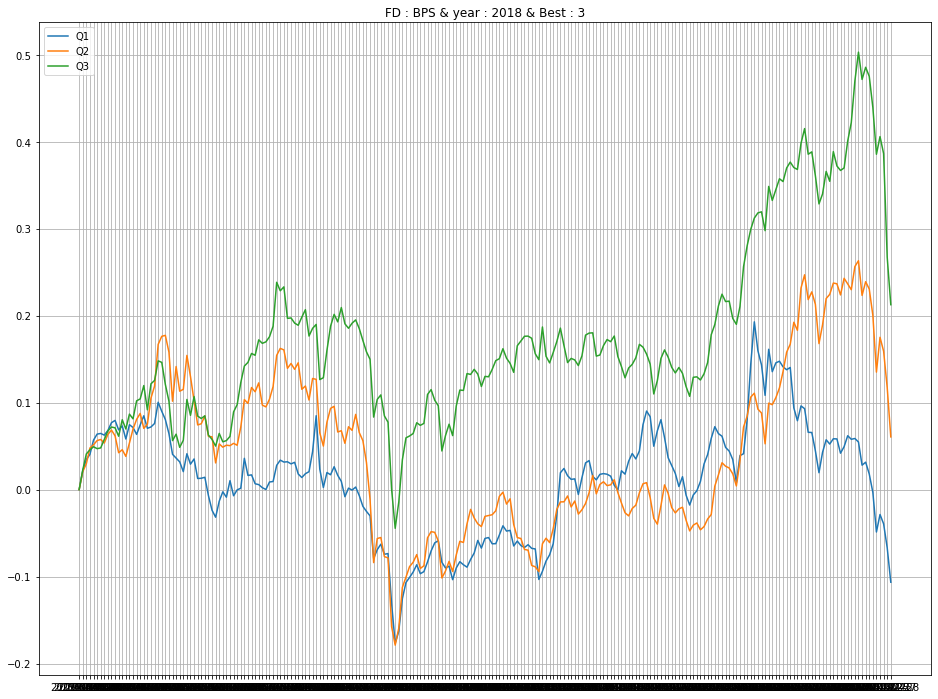

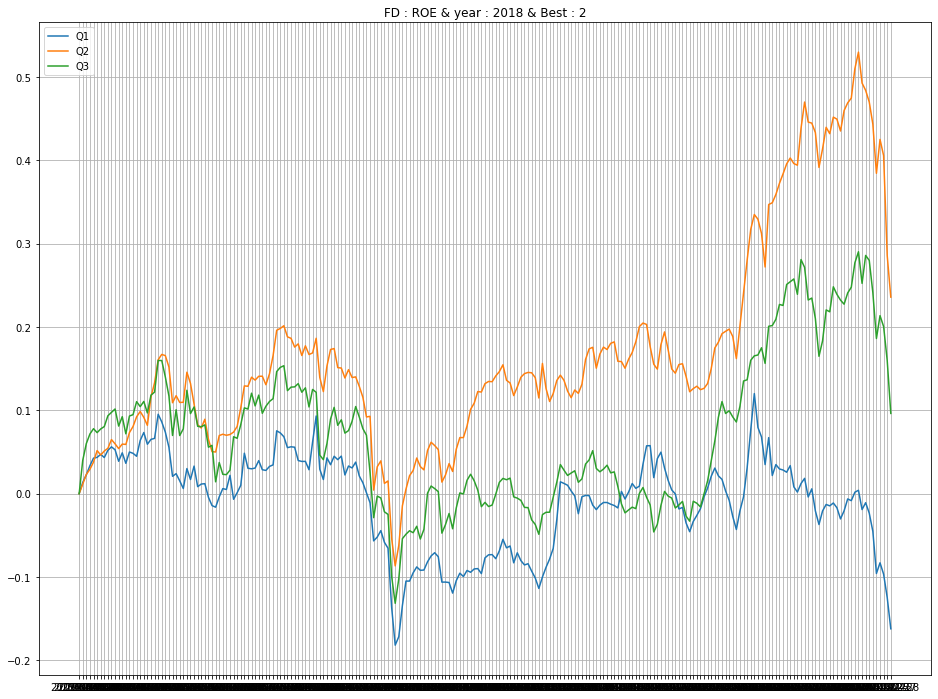

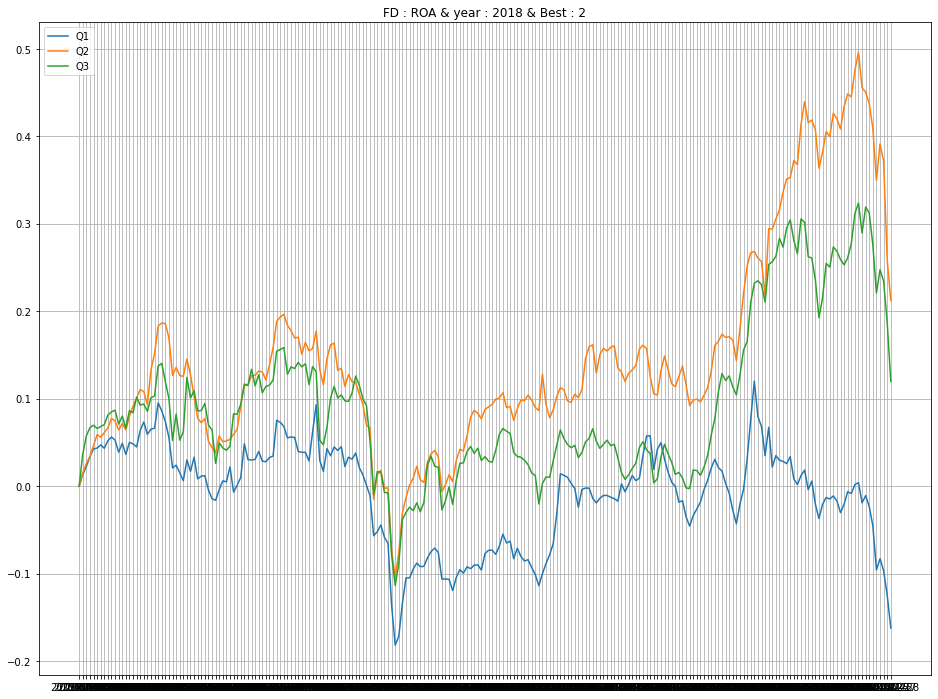

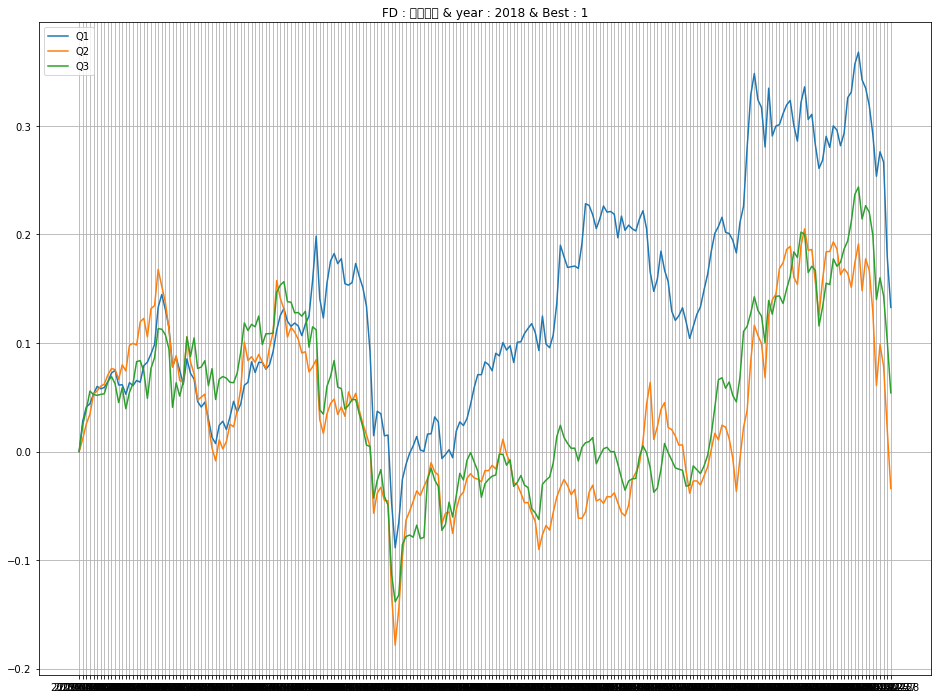

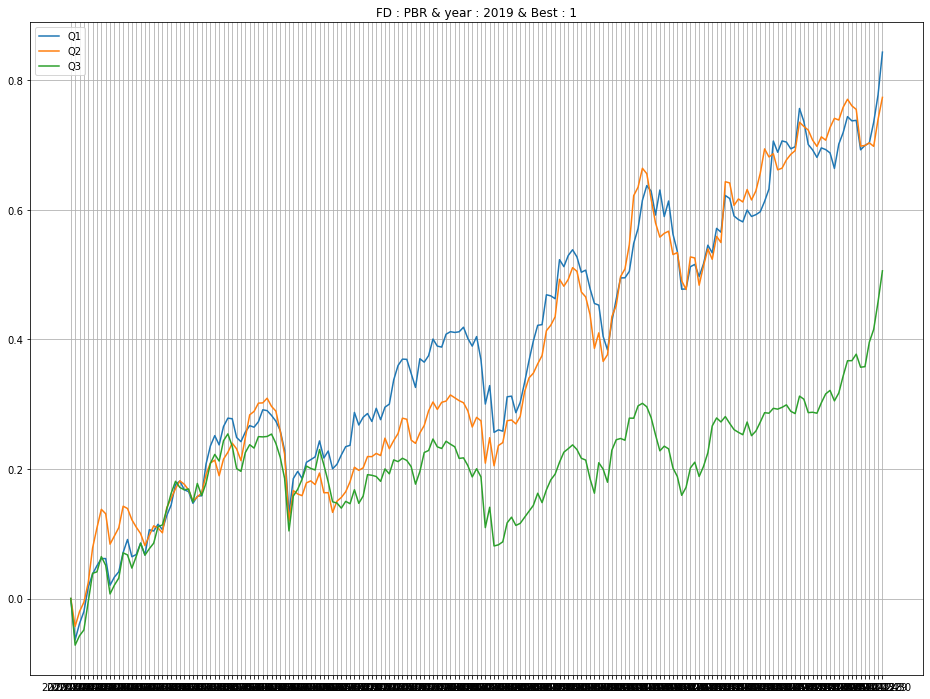

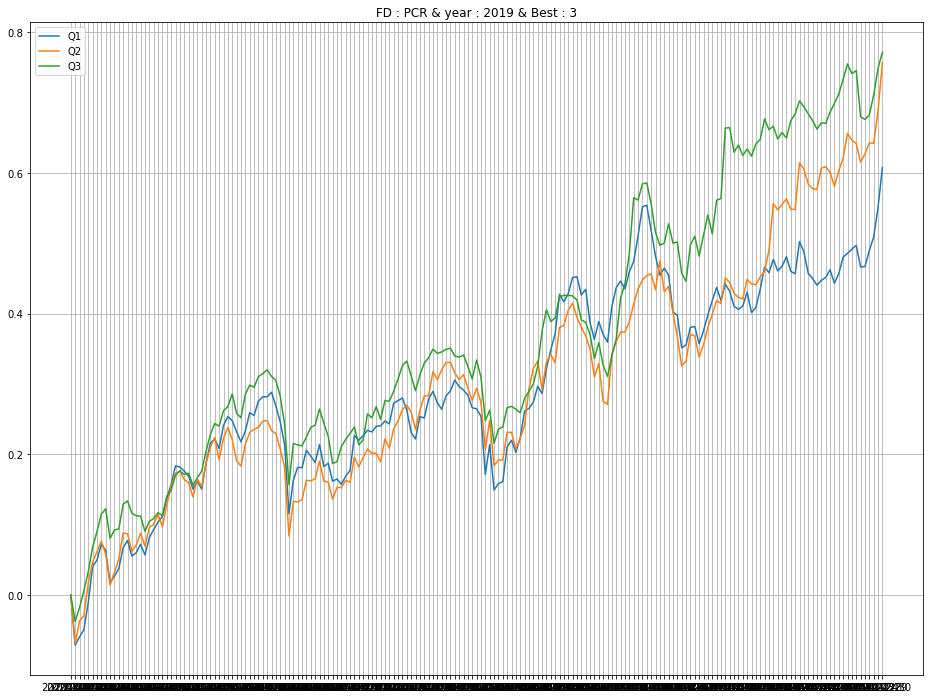

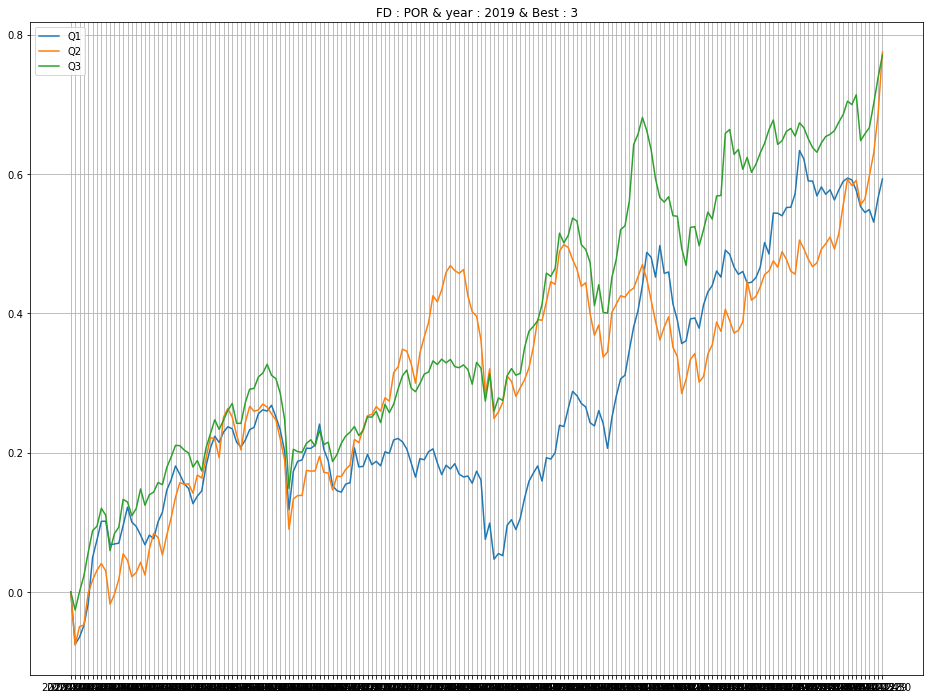

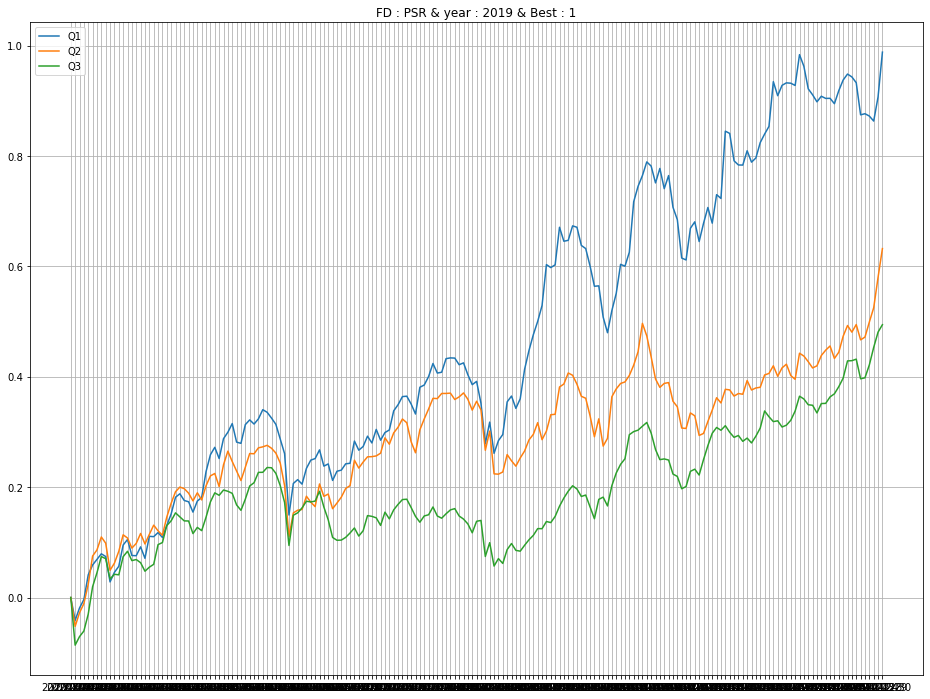

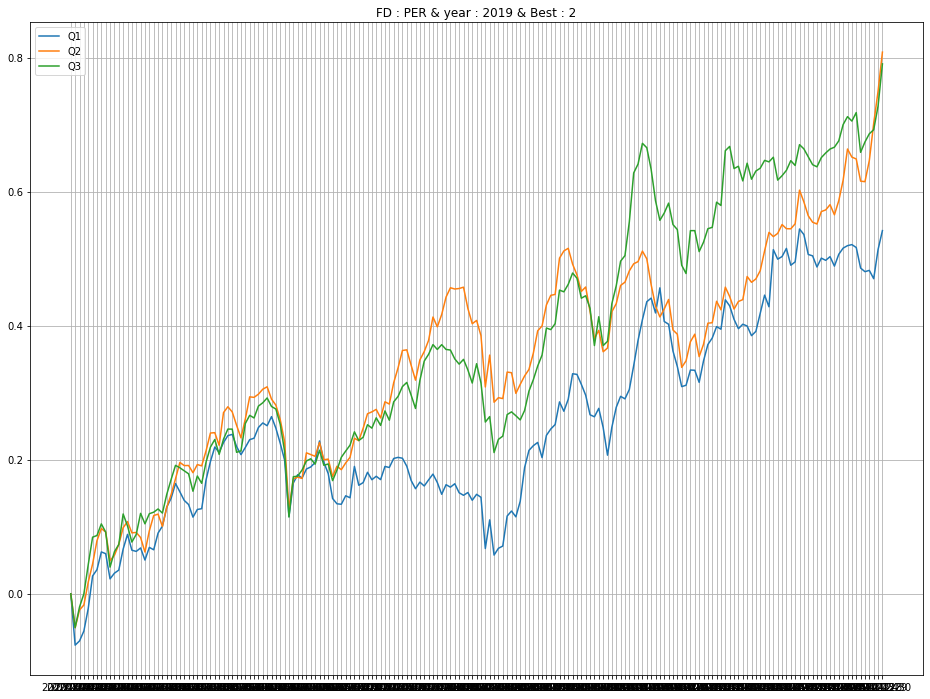

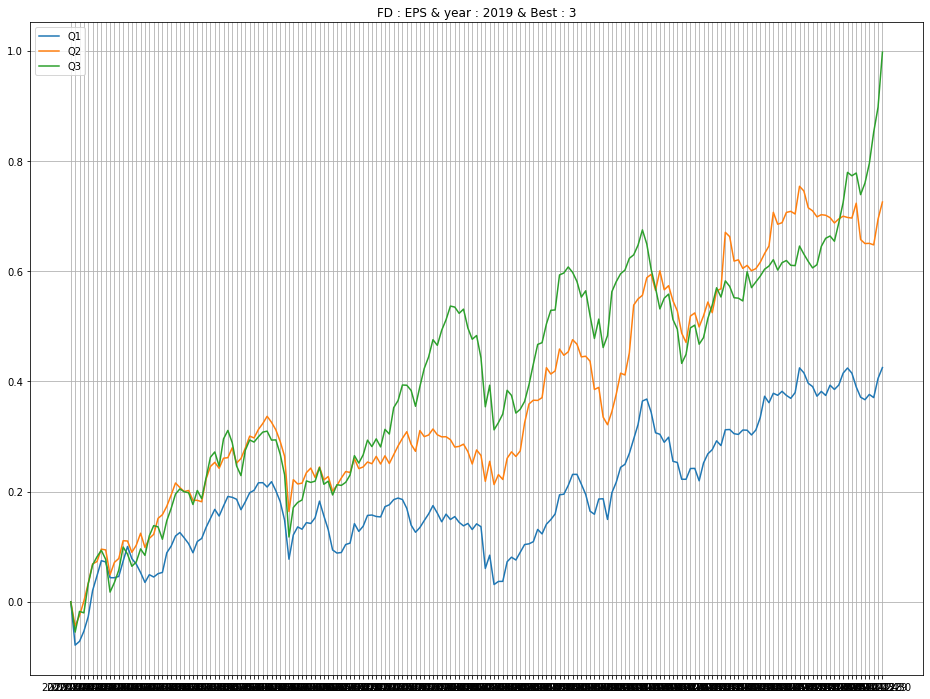

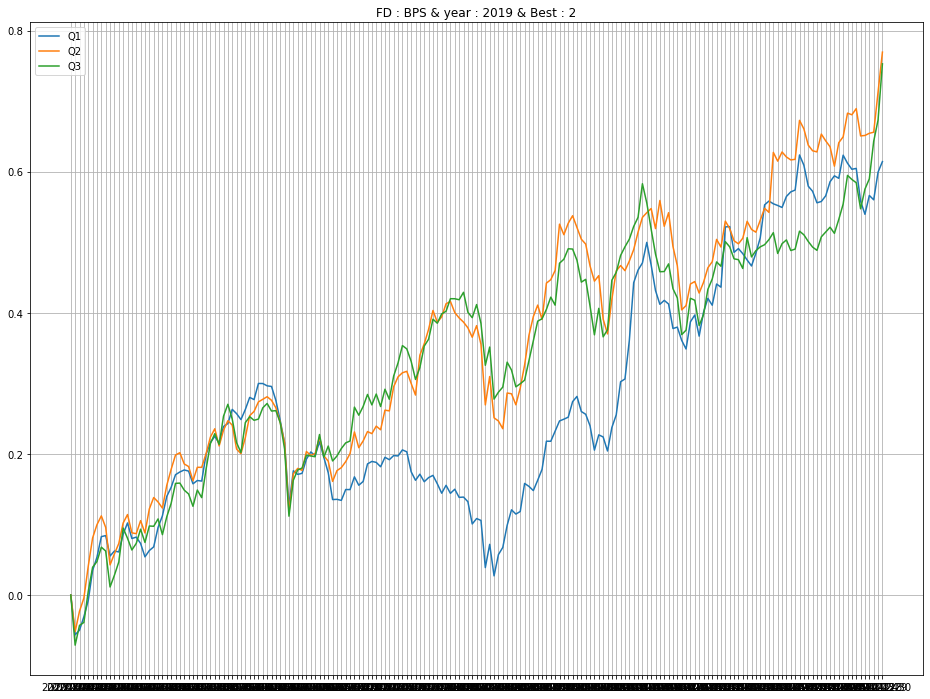

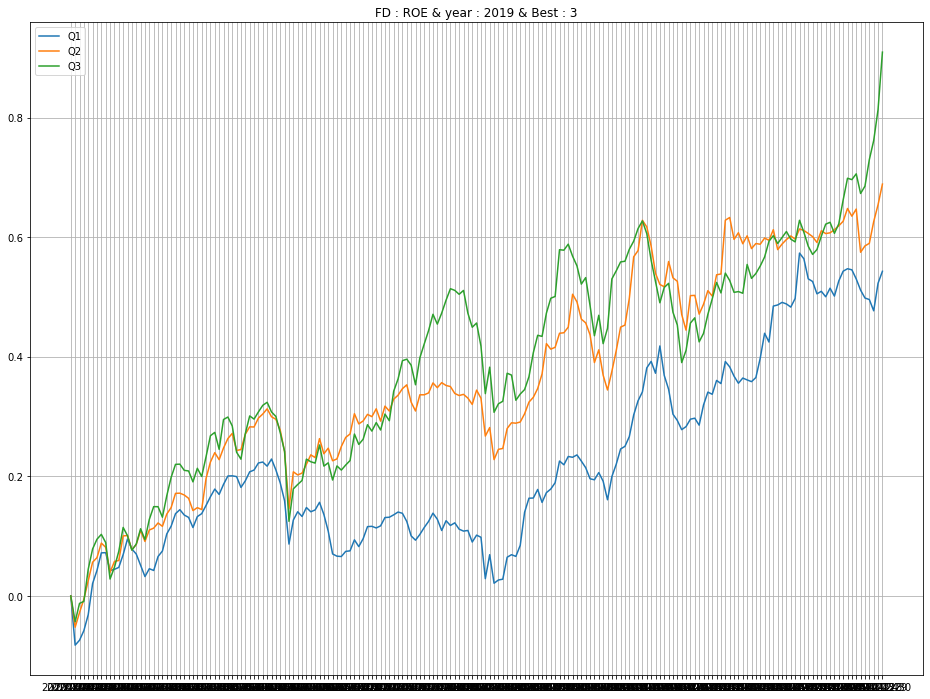

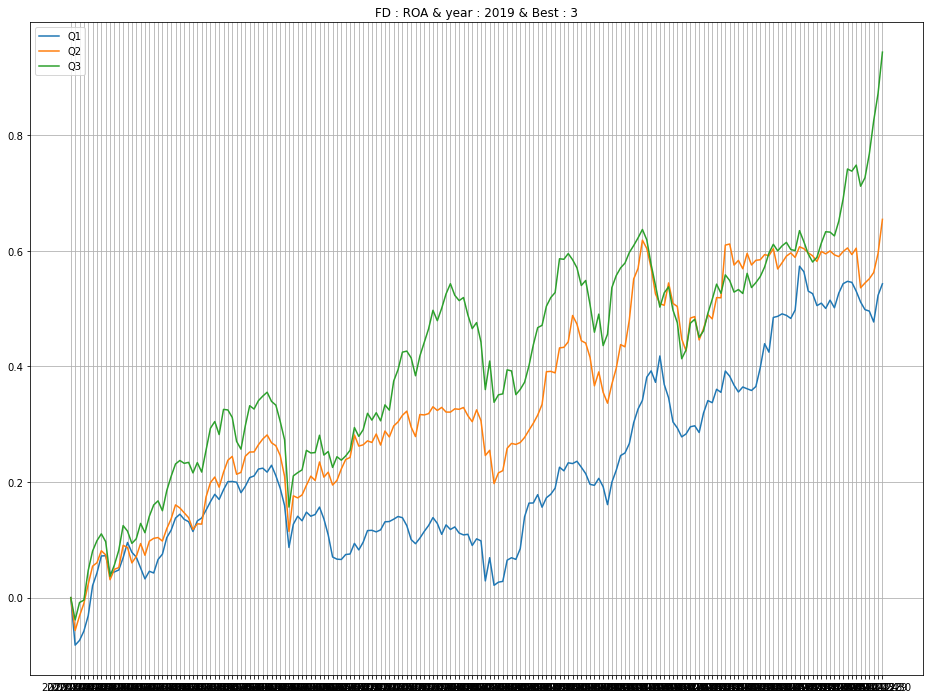

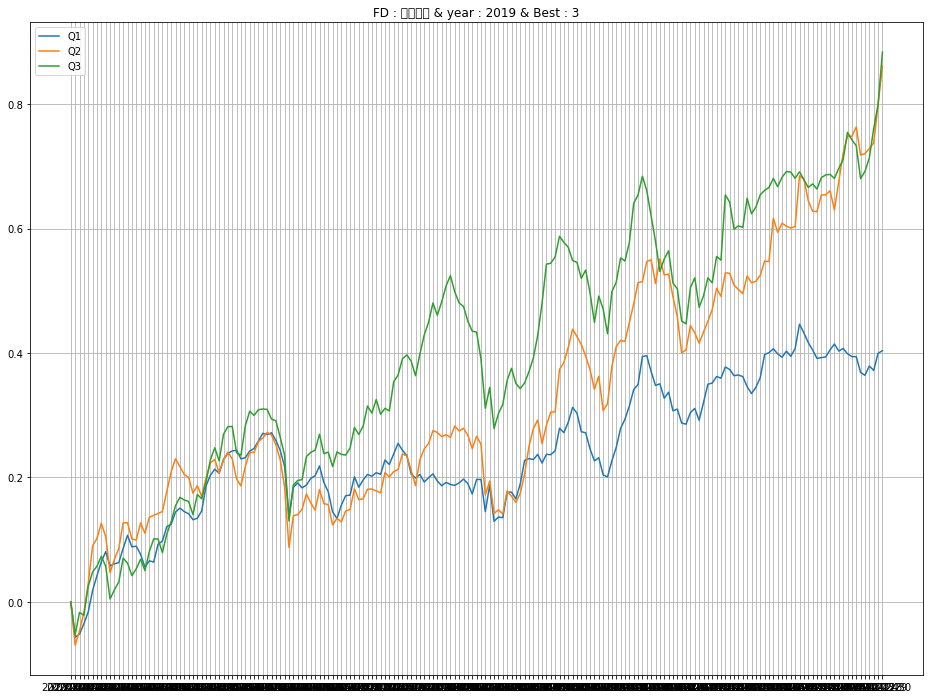

Wall time: 4min 18s


In [385]:
%%time
dfs = [sc2016,sc2017,sc2018,sc2019]
rst = FinalFundaER(dfs, resec)

In [386]:
rst.sort_values(by=['Funda','Date']).head(1)

Date Funda C31-Best     C31-Count
반도체 제조업  2016-12   BPS        2  [1, 136, 85]

In [22]:
resec.head(1)

Date Funda Pattern C31-Best      C31-Count C32-Best  \
기타 화학제품 제조업  2016-12   PBR       N        2  [1, 121, 100]        3   

                 C32-Count C33-Best        C33-Count  
기타 화학제품 제조업  [1, 109, 112]        3  [167, 222, 222]

In [17]:
%%time
dt = '2016-12'
sc2016 = SectorAnalysis_v3(dt,True)
dt = '2017-12'
sc2017 = SectorAnalysis_v3(dt,True)
dt = '2018-12'
sc2018 = SectorAnalysis_v3(dt,True)
dt = '2019-12'
sc2019 = SectorAnalysis_v3(dt,True)
dfs = [sc2016,sc2017,sc2018,sc2019]
resec = AnnualSectorDist_v4(dfs,True)

Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Initial Filtered Univ : 2411
EX : ['000020', '000040', '000050', '000060', '000070']
Wall time: 14min 6s


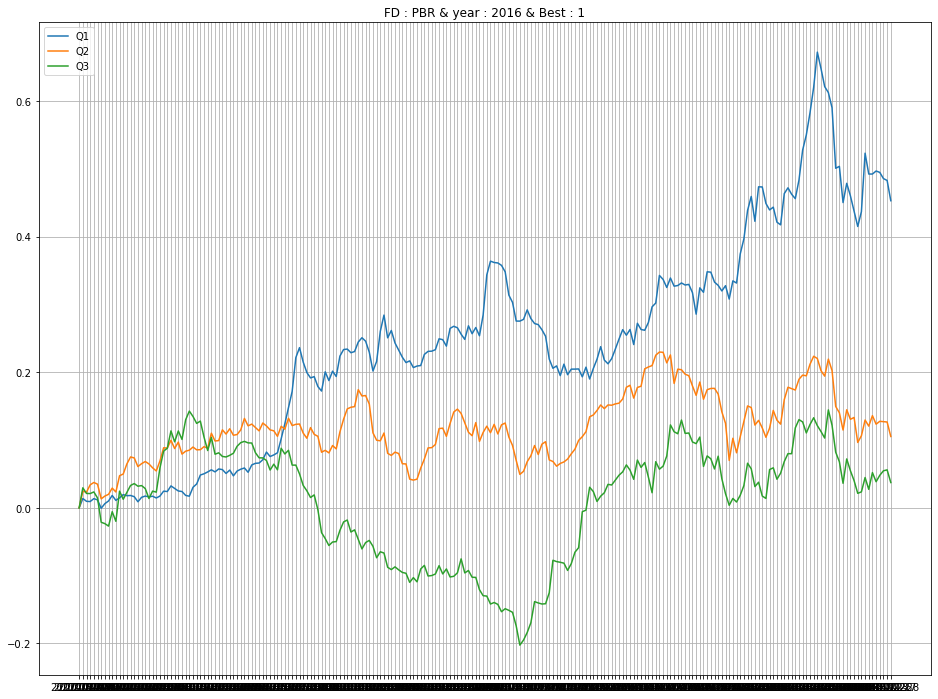

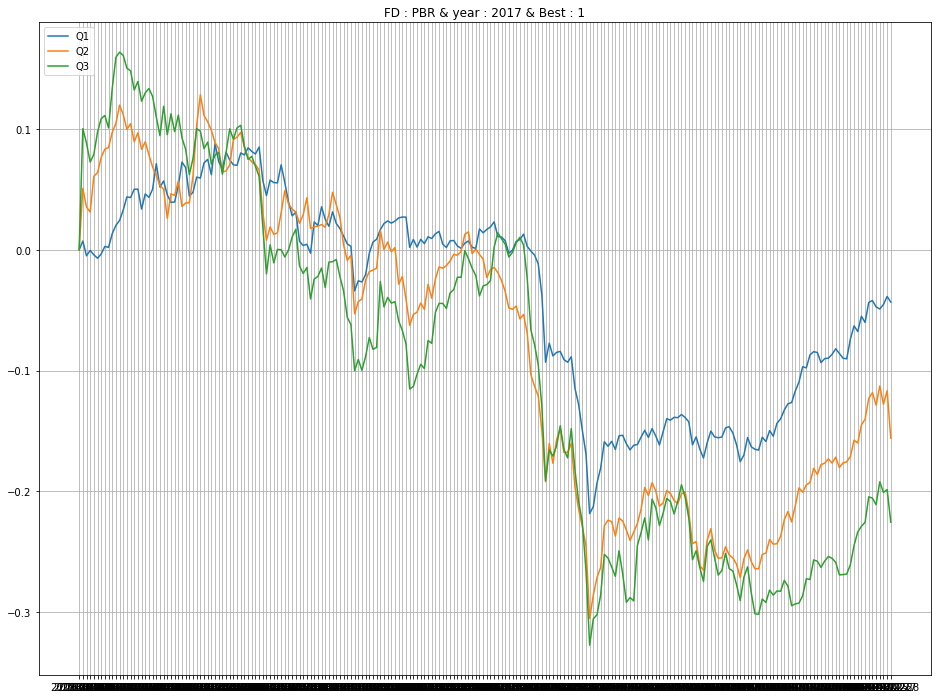

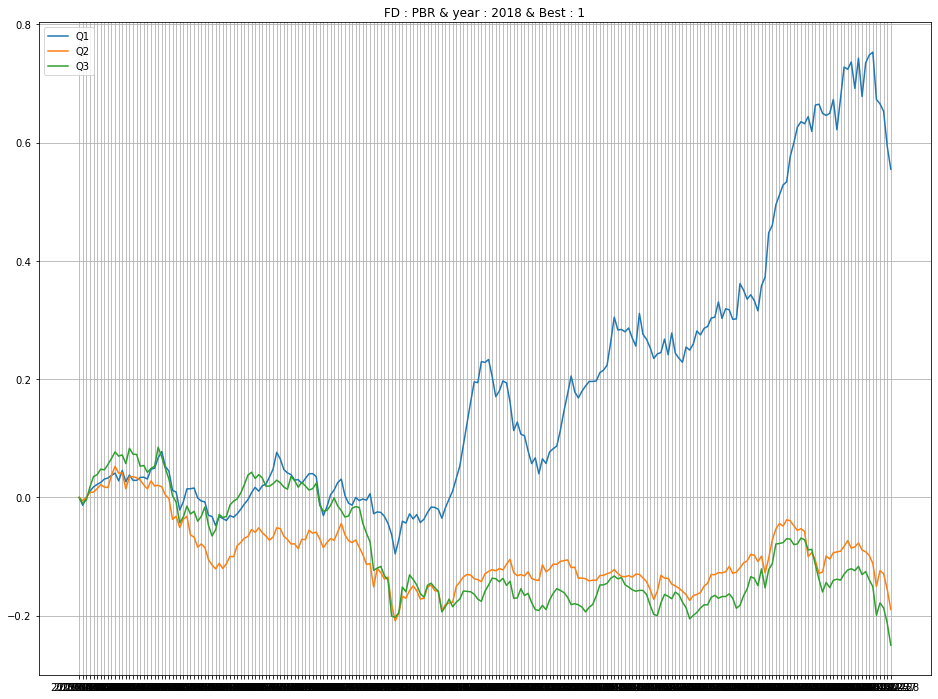

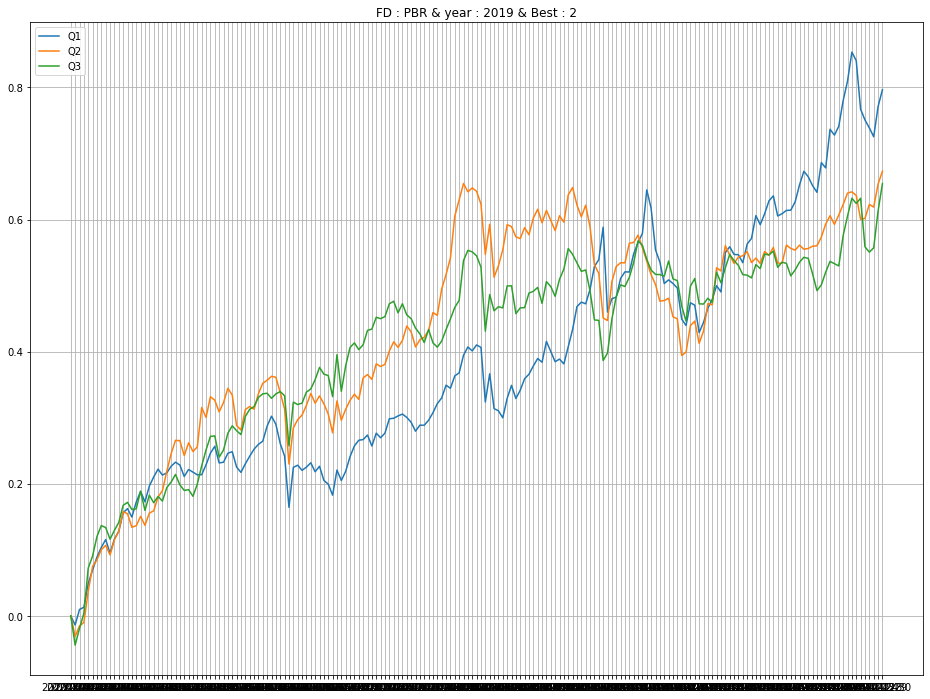

Wall time: 10min 56s


In [28]:
%%time
rst = FinalFundaER(dfs, resec)

In [32]:
rst[(rst.index.isin(['소프트웨어 개발 및 공급업']))&(rst.Funda=='PBR')]

Date Funda C31-Best      C31-Count
소프트웨어 개발 및 공급업  2016-12   PBR        1   [206, 16, 0]
소프트웨어 개발 및 공급업  2017-12   PBR        2  [76, 135, 11]
소프트웨어 개발 및 공급업  2018-12   PBR        3  [29, 66, 132]
소프트웨어 개발 및 공급업  2019-12   PBR        2   [3, 151, 33]

In [39]:
sc2019[(sc2019.index.isin(['소프트웨어 개발 및 공급업']))&(sc2019['FD-Q'].isin(['PBR-1','PBR-2','PBR-3']))]

FD-Q  C1     C1(%) C1(T) C2-GMean C2-MeanCodes  C2-Mean  \
소프트웨어 개발 및 공급업  PBR-1  34  0.918919    37  1.93369          NaN  1.47293   
소프트웨어 개발 및 공급업  PBR-2  33  0.916667    36  2.24054          NaN   1.6862   
소프트웨어 개발 및 공급업  PBR-3  32  0.864865    37  1.90569          NaN  1.60759   

                                                            Codes  
소프트웨어 개발 및 공급업  [030520, 035600, 040160, 042420, 046440, 04756...  
소프트웨어 개발 및 공급업  [032850, 041020, 041140, 041460, 057680, 05863...  
소프트웨어 개발 및 공급업  [023770, 030350, 032620, 036570, 042510, 04534...

In [40]:
rst

Date Funda C31-Best      C31-Count
기타 화학제품 제조업  2016-12   PBR        1  [167, 44, 11]
기타 화학제품 제조업  2016-12   PCR        3  [80, 39, 103]
기타 화학제품 제조업  2016-12   POR        2  [40, 164, 18]
기타 화학제품 제조업  2016-12   PSR        1  [166, 25, 31]
기타 화학제품 제조업  2016-12   PER        3   [96, 7, 119]
...              ...   ...      ...            ...
금융 지원 서비스업   2019-12   EPS        1   [123, 0, 64]
금융 지원 서비스업   2019-12   BPS        2   [26, 157, 4]
금융 지원 서비스업   2019-12   ROE        1   [107, 74, 6]
금융 지원 서비스업   2019-12   ROA        1   [177, 0, 10]
금융 지원 서비스업   2019-12  시가총액        2    [3, 182, 2]

[1080 rows x 4 columns]

In [41]:
with open("./FundaPattern_v2.pickle","wb") as fw:
    pickle.dump(rst, fw)

In [43]:
with open("./FundaPatternCodes_v2.pickle","wb") as fw:
    pickle.dump(dfs, fw)

In [ ]:
dfs